In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.io as io
import scipy.signal as signal
from scipy.optimize import curve_fit
import logging
import importlib
import os
from sklearn import linear_model
ransac = linear_model.RANSACRegressor()

import ephys_extractor as efex
import ephys_features as ft
sns.set_style('whitegrid')

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

%matplotlib inline

In [25]:
# Normally you don't change modules though
importlib.reload(efex)
importlib.reload(ft)

<module 'ephys_features' from '/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py'>

# Load and process data

In [26]:
# Hyppocampus files
# Check out all directories with its subdirectories and files. Every step in the for-loop checks the root, all the
# subdirectories and the files in the current directory (with name root). Save the file if .asc extension.
HC = []
HC_names = []
HC_suppl_info = []
for root, dirs, files in os.walk('../Hippocampus/Hippocampus Data Share with Yves/'):
    if files:
        for file in files:
            if file.endswith('.asc'):
                HC.append(root + '/' + file)
                HC_names.append(root + '/' + file)
                HC_suppl_info.append('..{}.txt'.format((root + '/' + file).split('.')[2]))

In [27]:
HC_names

['../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s2c4.asc',
 '../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s2c6.asc',
 '../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s5c19.asc',
 '../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s5c14.asc',
 '../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s5c17.asc',
 '../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s5c20.asc',
 '../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s2c5.asc',
 '../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s2c7.asc',
 '../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s6c22.asc',
 '../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s5c18.asc',
 '../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s2c8.asc',
 '../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180

In [5]:
def data_preparation_asc(data, suppl_data):
    """data_preparation_asc analyses the data in asc format (assumes a certain outlook of the data) and returns the voltage
    traces, stimulus current magnitudes for all traces and the time trace.
        
    Parameters
    ----------
    data : asc file of voltage (V) and time (s) traces
    suppl_data : file with supplementary information (current_step, current_start)

    
    Returns
    -------
    time : numpy 1D array of time points (s)
    voltage : numpy 2D array of voltage traces (mV)
    current : numpy 1D array of current stimulus magnitudes
    """
    
    # Splitting the file
    traces = open(data, 'r').read().split('\n') # Make a list of lines splitted by '\n'
    suppl_info = open(suppl_data, 'r').read().split('\n') # Analogous
    vol_traces_num = len(traces[0].split('\t')) - 1 # -1 since one trace should be the time trace
    time_points = len(traces) - 1 # The last line in these files should be an empty line
    voltage = np.zeros((time_points, vol_traces_num))
    time = np.zeros(time_points)
    for i, line in enumerate(traces[:-1]):
        time[i] = line.split('\t')[0]
        voltage[i, :] = line.split('\t')[1:]
    current_step = float(suppl_info[1].split(';')[1])
    current_start = float(suppl_info[2].split(';')[1])
    current_end = current_start + current_step*vol_traces_num
    current = np.arange(current_start, current_end, current_step)
    current_hold = float(suppl_info[0].split(';')[1])
    
    return time, voltage, current, current_hold

In [37]:
# 
time, voltage, current, current_hold = data_preparation_asc('../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s2c10.asc', \
                                              '../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s2c10.txt')

In [38]:
current_hold

-400.0

Text(0.5,1,'Raw voltage trace')

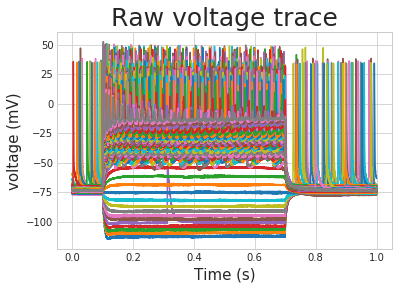

In [8]:
plt.plot(time, voltage)
plt.xlabel('Time (s)', fontsize = 15)
plt.ylabel('voltage (mV)', fontsize = 15)
plt.title('Raw voltage trace', fontsize = 25)

# Analysing spikes

In [9]:
def extract_spike_features(time, current, voltage, start = 0.1, end = 0.7, fil = 9):
    """ Analyse the voltage traces and extract information for every spike (returned in df), and information for all the spikes
    per current stimulus magnitude.

    Parameters
    ----------
    time : numpy 1D array of the time (s)
    current : numpy 1D array of all possible current stimulation magnitudes (pA)
    voltage : numpy ND array of all voltage traces (mV) corresponding to current stimulation magnitudes
    start : start of the stimulation (s) in the voltage trace (optional, default 0.1)
    end : end of the stimulation (s) in the voltage trace (optional, default 0.7)
    fil : cutoff frequency for 4-pole low-pass Bessel filter in kHz (optional, default 10)
    
    Returns
    -------
    df : DataFrame with information for every detected spike (peak_v, peak_index, threshold_v, ...)
    df_related_features : DataFrame with information for every possible used current stimulation magnitude
    """
    
    df = pd.DataFrame()
    df_related_features = pd.DataFrame()
    for c, curr in enumerate(current):
        current_array = curr*np.ones_like(time)
        start_index = (np.abs(time - start)).argmin() # Find closest index where the injection current starts
        end_index = (np.abs(time - end)).argmin() # Find closest index where the injection current ends
        current_array[:start_index] = 0
        current_array[end_index:len(current_array)] = 0
        EphysObject = efex.EphysSweepFeatureExtractor(t = time, v = voltage[:, c], i = current_array, start = start, \
                                                      end = end, filter = fil)
        EphysObject.process_spikes()
        #if EphysObject._spikes_df.size:
        #    #Random threshold 15 for now but:
        #    if np.abs(EphysObject._get_baseline_voltage() - np.mean(EphysObject._spikes_df['threshold_v'].values)) < 15:
        #        print('Too steep depolarisation here.')
        #        EphysObject = efex.EphysSweepFeatureExtractor(t = time, v = voltage[:, c], i = current_array, start = 0.1005, \
        #                                                     end = end, filter = fil)
        
        # Adding peak_height (mV) + code for maximum frequency determination (see further)
        spike_count = 0
        if EphysObject._spikes_df.size:
            EphysObject._spikes_df['peak_height'] = EphysObject._spikes_df['peak_v'].values - \
                                                   EphysObject._spikes_df['threshold_v'].values
            # If the spike amplitude didn't go above 8 mV's (random threshold for now), it's probably still noise
            EphysObject._spikes_df = EphysObject._spikes_df[EphysObject._spikes_df['peak_height'].values > 8]
            spike_count = EphysObject._spikes_df['threshold_i'].values.size
        df = pd.concat([df, EphysObject._spikes_df], sort = True)

        # Some easily found extra features
        df_features = EphysObject._sweep_features

        # Adding spike count
        df_features.update({'spike_count': spike_count})
        
        # Adding current (pA)
        df_features.update({'current': curr})

        # Adding membrane voltage (mV)
        df_features.update({'resting_membrane_potential': EphysObject._get_baseline_voltage()})

        # Adding voltage deflection (mV)
        voltage_deflection_v, voltage_deflection_i = EphysObject.voltage_deflection()
        df_features.update({'voltage_deflection': voltage_deflection_v})
        
        # Adding input resistance (MOhm)
        # How to calculate the input resistance is not clear yet but this could be an option (although in function
        # get_cell_features it is being calculated differently)
        input_resistance = np.nan
        if not ('peak_i' in EphysObject._spikes_df.keys()) and not curr==0: # We only calculate input resistances 
                                                                            # from traces without peaks
            input_resistance = (np.abs(voltage_deflection_v - EphysObject._get_baseline_voltage())*1000)/np.abs(curr)
            if input_resistance == np.inf:
                input_resistance = np.nan
        df_features.update({'input_resistance': input_resistance})

        # Adding membrane time constant (s) and voltage plateau level for hyperpolarisation paradigms after stimulus onset
        tau = np.nan
        E_plat = np.nan
        sag_ratio = np.nan
        if curr < current_hold: # We use hyperpolarising steps as required in the object function to estimate the
                                # membrane time constant and E_plateau
            while True:
                try:
                    tau = EphysObject.estimate_time_constant()  # Result in seconds!
                    break
                except TypeError: # Probably a noisy bump for this trace, just keep it to be np.nan
                    break
            E_plat = ft.average_voltage(voltage[:, c], time, start = end - 0.1, end = end)
            sag, sag_ratio = EphysObject.estimate_sag()
        df_features.update({'tau': tau})
        df_features.update({'E_plat': E_plat})
        df_features.update({'sag_ratio': sag_ratio})


        df_related_features = pd.concat([df_related_features, pd.DataFrame([df_features])], sort = True)
    
    return df, df_related_features

In [40]:
#1/((time[1]-time[0])*1e3*2)-0.5
df, df_related_features = extract_spike_features(time, current, voltage, fil = 8)

In [608]:
start = 3300
end = 3500

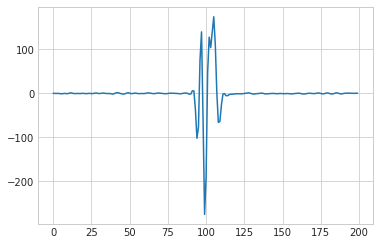

In [609]:
dvdt = ft.calculate_dvdt(voltage[:, 10], time, 6)
plt.plot(dvdt[start:end])

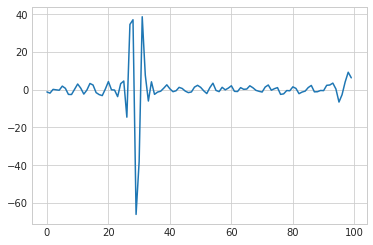

In [580]:
dvdt = ft.calculate_dvdt(voltage[:, 26], time, 8)
plt.plot(dvdt[start:end])

Text(0.5,1,'Raw voltage trace')

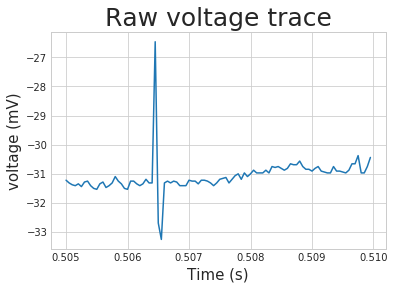

In [582]:
plt.plot(time[start:end], voltage[start:end, 26])
plt.xlabel('Time (s)', fontsize = 15)
plt.ylabel('voltage (mV)', fontsize = 15)
plt.title('Raw voltage trace', fontsize = 25)

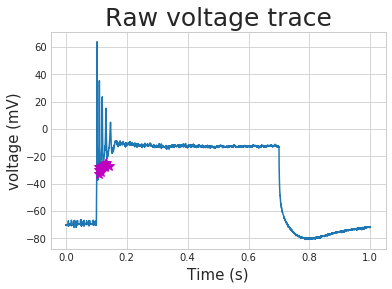

In [658]:
plt.plot(time, voltage[:, 45])
plt.xlabel('Time (s)', fontsize = 15)
plt.ylabel('voltage (mV)', fontsize = 15)
plt.title('Raw voltage trace', fontsize = 25)
plt.plot(time[df['threshold_index'][df['threshold_i'].values > 580].values][:15], \
         voltage[df['threshold_index'][df['threshold_i'].values > 580].values[:15], 36], marker = '*', color = 'm', markersize = 10)

In [632]:
time[df['threshold_index'][df['threshold_i'].values > 400].values]

array([0.10124, 0.10976, 0.12116, 0.13372, 0.148  , 0.16076, 0.16548,
       0.18864, 0.24096, 0.28172, 0.33632, 0.44084, 0.57572, 0.6018 ,
       0.61576, 0.10984, 0.1208 , 0.13312, 0.14852, 0.16772, 0.1096 ,
       0.11988, 0.13208, 0.1474 , 0.16628, 0.10924, 0.12028, 0.13236,
       0.14596, 0.16364, 0.10948, 0.11964, 0.13228, 0.14732, 0.10196,
       0.10908, 0.119  , 0.13128, 0.14636, 0.10868, 0.119  , 0.13156,
       0.1462 , 0.10896, 0.1188 , 0.13144, 0.1084 , 0.11816, 0.14424,
       0.15116, 0.15164, 0.15248, 0.15408, 0.15844, 0.15876, 0.15916,
       0.16408, 0.17408, 0.18404, 0.21404, 0.22148, 0.22192, 0.22348,
       0.22392, 0.2248 , 0.22588, 0.31112, 0.31148, 0.3118 , 0.31348,
       0.31392, 0.31444, 0.31476, 0.31812, 0.319  , 0.33404, 0.35408,
       0.36408, 0.38412, 0.41432, 0.42412, 0.44432, 0.45432, 0.49432,
       0.51432, 0.54432, 0.10852, 0.11528, 0.12912, 0.1302 , 0.19548,
       0.10612, 0.11732, 0.12812, 0.1072 , 0.1218 , 0.12852, 0.14176,
       0.16176, 0.18

In [643]:
df.keys()

Index(['threshold_index', 'clipped', 'trough_index', 'trough_t', 'trough_v',
       'trough_i', 'peak_index', 'peak_t', 'peak_v', 'peak_i', 'threshold_t',
       'threshold_v', 'threshold_i', 'upstroke_index', 'upstroke',
       'upstroke_t', 'upstroke_v', 'downstroke_index', 'downstroke',
       'downstroke_t', 'downstroke_v', 'isi_type', 'slow_trough_index',
       'slow_trough_t', 'slow_trough_v', 'slow_trough_i', 'adp_index', 'adp_t',
       'adp_v', 'adp_i', 'fast_trough_index', 'fast_trough_t', 'fast_trough_v',
       'fast_trough_i', 'width', 'upstroke_downstroke_ratio', 'peak_height'],
      dtype='object')

In [656]:
df[['threshold_v', 'threshold_index', 'threshold_i', 'peak_height']][df['threshold_i'].values > 580]

threshold_v  threshold_index  threshold_i  peak_height
1   -18.755432             2717        600.0    54.046904
2   -23.037923             2882        600.0    46.544732
3   -11.065705             3233        600.0     8.252390
4    -3.407237             3255        600.0    18.567878
1   -21.287416             2703        620.0    55.015935
2   -17.411293             2933        620.0    40.199143
3   -14.066574             3216        620.0    27.945594
1   -23.725622             2680        640.0    56.828960
3   -12.097254             3213        640.0    26.070051
4   -10.378006             3544        640.0    13.097544

In [62]:
current[23]

-140.0

In [53]:
current_hold

-400.0

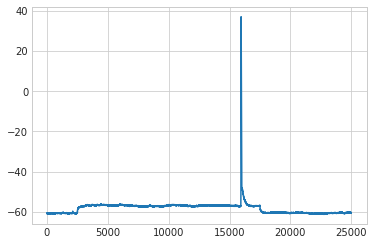

In [58]:
plt.plot(voltage[:, 12])

/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:827: RuntimeWarning: divide by zero encountered in true_divide
  dvdt = 1e-3 * dv / dt # in V/s = mV/ms


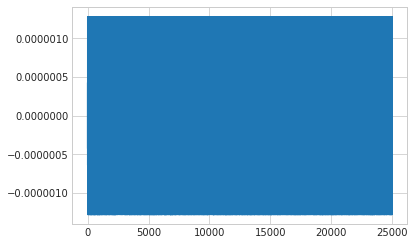

In [70]:
plt.plot(ft.calculate_dvdt(time, voltage[:, 23], filter = 7))

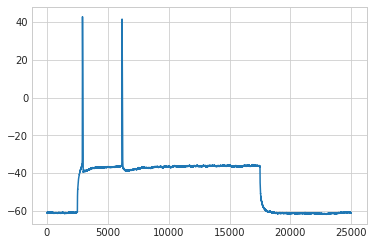

In [64]:
plt.plot(voltage[:, 23])

In [41]:
df_related_features

E_plat     adapt  adaptation_index   avg_rate  current  first_isi  \
0  -79.766804       NaN               NaN   0.000000   -600.0        NaN   
0  -77.017795       NaN               NaN   0.000000   -580.0        NaN   
0  -74.931291       NaN               NaN   0.000000   -560.0        NaN   
0  -73.554367       NaN               NaN   0.000000   -540.0        NaN   
0  -71.355005       NaN               NaN   0.000000   -520.0        NaN   
0  -69.733923       NaN               NaN   0.000000   -500.0        NaN   
0  -68.599707       NaN               NaN   0.000000   -480.0        NaN   
0  -66.909130       NaN               NaN   0.000000   -460.0        NaN   
0  -65.033511       NaN               NaN   0.000000   -440.0        NaN   
0  -63.082171       NaN               NaN   3.333333   -420.0    0.07948   
0         NaN       NaN               NaN   0.000000   -400.0        NaN   
0         NaN       NaN               NaN   0.000000   -380.0        NaN   
0         NaN       NaN               NaN   1.666667   -360.0        NaN   
0         NaN       NaN               NaN   0.000000   -340.0        NaN   
0         NaN       NaN               NaN   0.000000   -320.0        NaN   
0         NaN       NaN               NaN   0.000000   -300.0        NaN   
0         NaN       NaN               NaN   1.666667   -280.0        NaN   
0         NaN       NaN               NaN   0.000000   -260.0        NaN   
0         NaN       NaN               NaN   3.333333   -240.0    0.46200   
0         NaN       NaN               NaN   0.000000   -220.0        NaN   
0         NaN       NaN               NaN   1.666667   -200.0        NaN   
0         NaN       NaN               NaN   1.666667   -180.0        NaN   
0         NaN       NaN               NaN   0.000000   -160.0        NaN   
0         NaN       NaN               NaN   3.333333   -140.0    0.12996   
0         NaN       NaN               NaN   3.333333   -120.0    0.22716   
0         NaN -0.613685               NaN   5.000000   -100.0    0.42356   
0         NaN       NaN               NaN   1.666667    -80.0        NaN   
0         NaN       NaN               NaN   3.333333    -60.0    0.20072   
0         NaN       NaN               NaN   3.333333    -40.0    0.59404   
0         NaN  0.659742               NaN   5.000000    -20.0    0.06224   
..        ...       ...               ...        ...      ...        ...   
0         NaN  0.394973        513.333333   8.333333    120.0    0.01440   
0         NaN  0.289923        275.961538  10.000000    140.0    0.01248   
0         NaN  0.297308        192.358804  10.000000    160.0    0.01204   
0         NaN  0.358364        186.195286   8.333333    180.0    0.01188   
0         NaN  0.331625        191.463415   6.666667    200.0    0.01312   
0         NaN  0.575942        158.585859   6.666667    220.0    0.01188   
0         NaN  0.318911        143.636364   8.333333    240.0    0.01100   
0         NaN  0.208113        143.109541  10.000000    260.0    0.01132   
0         NaN  0.369620        136.654804   8.333333    280.0    0.01124   
0         NaN  0.249515        184.090909   6.666667    300.0    0.01056   
0         NaN  0.220392        164.363636   8.333333    320.0    0.01100   
0         NaN  0.474424        144.055944   6.666667    340.0    0.01144   
0         NaN  0.219555        135.826772   5.000000    360.0    0.01016   
0         NaN  0.413210        156.896552   6.666667    380.0    0.00928   
0         NaN  0.376187        148.878924   6.666667    400.0    0.00892   
0         NaN  0.469405        150.000000   5.000000    420.0    0.00848   
0         NaN  0.100000        161.325967  10.000000    440.0    0.00724   
0         NaN  0.296230        145.500000  10.000000    460.0    0.00800   
0         NaN  0.264075        155.276382  10.000000    480.0    0.00796   
0         NaN  0.443354        141.025641   5.000000    500.0    0.00780   
0         NaN  0.499674        164.285714   6.666667   

In [59]:
df

threshold_index  clipped  threshold_t  threshold_v  threshold_i  \
0             11352    False      0.45408   -62.674403       -420.0   
1             13339    False      0.53356   -62.174258       -420.0   
0             15927    False      0.63708   -56.547629       -360.0   
0              3874    False      0.15496   -47.638798       -280.0   
0              3704    False      0.14816   -44.512893       -240.0   
1             15254    False      0.61016   -44.419116       -240.0   
0             12630    False      0.50520   -40.668029       -200.0   
0              4276    False      0.17104   -38.542413       -180.0   
0              2903    False      0.11612   -34.197405       -140.0   
1              6152    False      0.24608   -35.822876       -140.0   
0              2835    False      0.11340   -33.822296       -120.0   
1              8514    False      0.34056   -34.009851       -120.0   
0              2753    False      0.11012   -33.634742       -100.0   
1             13342    False      0.53368   -31.946753       -100.0   
2             15877    False      0.63508   -33.478447       -100.0   
0              2712    False      0.10848   -33.384670        -80.0   
0              2663    False      0.10652   -33.072079        -60.0   
1              7681    False      0.30724   -27.382931        -60.0   
0              2639    False      0.10556   -33.009561        -40.0   
1             17490     True      0.69960   -25.476129        -40.0   
0              2625    False      0.10500   -32.603193        -20.0   
1              4181    False      0.16724   -27.382931        -20.0   
2             11771    False      0.47084   -24.788430        -20.0   
0              2611    False      0.10444   -31.790458          0.0   
1              4302    False      0.17208   -24.569616          0.0   
2             15423    False      0.61692   -24.850948          0.0   
0              2604    False      0.10416   -31.352831         20.0   
1              3267    False      0.13068   -24.382062         20.0   
2              7216    False      0.28864   -25.851238         20.0   
3             14240    False      0.56960   -22.787850         20.0   
..              ...      ...          ...          ...          ...   
4              3672    False      0.14688    -4.563822        600.0   
5             11947    False      0.47788    -6.032997        600.0   
6             16359    False      0.65436    -5.970479        600.0   
7             17090     True      0.68360    -6.908251        600.0   
0              2499    False      0.09996   -66.706821          0.0   
1              2660    False      0.10640    -8.127354        620.0   
2              2898    False      0.11592    -3.000869        620.0   
3              3298    False      0.13192    -1.031549        620.0   
4              5839    False      0.23356    -1.594212        620.0   
5             10587     True      0.42348    -5.095226        620.0   
0              2499    False      0.09996   -65.706531          0.0   
1              2652    False      0.10608    -9.190162        640.0   
2              2866    False      0.11464    -3.032128        640.0   
3              3191    False      0.12764    -0.625181        640.0   
4              7596     True      0.30384    -4.345008        640.0   
0              2499    False      0.09996   -66.331712          0.0   
1              2661    False      0.10644    -7.814763        660.0   
2              2870    False      0.11480    -1.750507        660.0   
3              3211    False      0.12844     0.125036        660.0   
4             16130     True      0.64520    -4.501304        660.0   
0              2499    False      0.09996   -66.581785          0.0   
1              2661    False      0.10644    -6.220552        680.0   
2              2884    False      0.11536    -0.218813        680.0   
3              3216     True      0.12864     1.281621        680.0   
0              2499    False

In [2]:
def get_cell_features(df, df_related_features, curr_hold):
    """ Analyse all the features available for the cell per spike and per current stimulation magnitude. Extract typical
    features includig the resting membrane potential (Rm, mV), the input resistance (Ri, MOhm), the membrane time constant
    (tau, ms), the action potential threshold (AP threshold, mV), the action potential amplitude (AP amplitude, mV),
    the action potential half-width (AP half-width, ms), the afterhyperpolarisation (AHP, mV), the afterdepolarisation
    (ADP, mV), the adaptation index (AI, %) and the maximum firing frequency (max freq, Hz).
    
    Parameters
    ----------
    df : DataFrame with information for every detected spike
    df_related_features : DataFrame with information for every possible used current stimulation magnitude
    curr_hold : holding current (current clamp) before current stimulation
    Returns
    ----------
    Cell_Features : DataFrame with values for all required features mentioned above
    """
    temp_df = df_related_features[['current', 'E_plat']].dropna()
    # The following is based on experimental paradigms where the voltage before stimulation is not necessary the resting
    # membrane potential. The first 5 hyperpolarisation traces below the first trace that shows depolarisation are taken into
    # account. A robust against outliers regression analysis is then performed (does this make sense for only 5 datapoints?) 
 
    if (temp_df.shape[0] >= 4):
        ransac.fit(temp_df['current'][-5:].values.reshape(-1, 1), \
                   temp_df['E_plat'][-5:].values.reshape(-1, 1))
        line_X = np.concatenate((temp_df['current'][-5:].values, \
                                 np.array([0]))).reshape(-1, 1)
        Ri = ransac.estimator_.coef_[0][0]*1000
        Rm = ransac.predict(np.array([0]).reshape(-1, 1))[0][0]
    else: # Just take as many hyperpolarisation traces available
        ransac.fit(temp_df['current'].values.reshape(-1, 1), \
                   temp_df['E_plat'].values.reshape(-1, 1))
        line_X = np.concatenate((temp_df['current'].values, np.array([0]))).reshape(-1, 1)
        Ri = ransac.estimator_.coef_[0][0]*1000
        Rm = ransac.predict(np.array([0]).reshape(-1, 1))[0][0]
        
    print('Rm: ', Rm)
    print('Ri: ', Ri)
    if (temp_df.shape[0] >= 4):
        plt.plot(temp_df['current'][-5:].values.reshape(-1, 1), \
                   temp_df['E_plat'][-5:].values.reshape(-1, 1), '.m')
    else:
        plt.plot(temp_df['current'].values.reshape(-1, 1), \
                   temp_df['E_plat'].values.reshape(-1, 1), '.m')
    plt.plot(line_X, ransac.predict(line_X))
    plt.legend(['data', 'regression robust to outliers'])
    plt.xlim([-500,  150])
    plt.xlabel('current')
    plt.ylabel('E_plat')
    plt.title('regression analysis')
    
    # We consider all hyperpolarisation traces but perform an average without outliers (outliers are defined as lying above
    # or below 2 standard deviations from the mean)
    tau_array = df_related_features['tau'].dropna().values
    tau = np.median(tau_array)
    #sag_ratio_array = df_related_features['sag_ratio'].dropna().values
    
    #mean_tau = np.mean(tau_array, axis = 0)
    #mean_sag_ratio = np.mean(sag_ratio_array, axis = 0)
    
    #sd_tau = np.std(tau_array, axis = 0)
    #sd_sag_ratio = np.std(sag_ratio_array, axis = 0)
    
    #tau_array_non_outliers = [x for x in tau_array if (x > mean_tau - 2*sd_tau)]
    #sag_ratio_array_non_outliers = [x for x in sag_ratio_array if (x > mean_sag_ratio - 2*sd_sag_ratio)]
    
    #tau_array_non_outliers = [x for x in tau_array_non_outliers if (x < mean_tau + 2*sd_tau)]
    #sag_ratio_array_non_outliers = [x for x in sag_ratio_array_non_outliers if (x < mean_sag_ratio + 2*sd_sag_ratio)]
    
    #tau = np.mean(np.array(tau_array_non_outliers))*1000
    #sag_ratio = np.mean(np.array(sag_ratio_array_non_outliers))
    sag_ratio = df_related_features['sag_ratio'].dropna().values[0] # Steepest hyperpolarising trace used
    
    if not df.empty:
        max_freq = np.max(df_related_features['spike_count'].values)
        
        non_nan_indexes_AI = ~np.isnan(df_related_features['adaptation_index'].values)
        
        if non_nan_indexes_AI.any():
            # Consider only the first 5 after threshold reached if possible
            # np.sum will consider a True as a 1 here and a False as a 0 (so you cound the True's effectively)
            if  np.sum(non_nan_indexes_AI) >= 5:
                AI_array = df_related_features['adaptation_index'].values[non_nan_indexes_AI][0:6]
                AI = np.median(AI_array)
                # Now let's not include outliers
                #mean_AI = np.mean(AI_array, axis = 0)
                #sd_AI = np.std(AI_array, axis = 0)
                #AI_array_non_outliers = [x for x in AI_array if (x > mean_AI - 2*sd_AI)]
                #AI_array_non_outliers = [x for x in AI_array_non_outliers if (x < mean_AI + 2*sd_AI)]
                #AI = np.mean(AI_array_non_outliers)
            else: # Take everything you have
                AI_array = df_related_features['adaptation_index'].values[non_nan_indexes_AI]
                AI = np.median(AI_array)
                # Now let's not include outliers
                #mean_AI = np.mean(AI_array, axis = 0)
                #sd_AI = np.std(AI_array, axis = 0)
                #AI_array_non_outliers = [x for x in AI_array if (x > mean_AI - 2*sd_AI)]
                #AI_array_non_outliers = [x for x in AI_array_non_outliers if (x < mean_AI + 2*sd_AI)]
                #AI = np.mean(AI_array_non_outliers)
        else:
            AI = 0
        
        
        # We calculate the latency: the time it takes to elicit the first spike
        df_latency = df_related_features[df_related_features['current'] > curr_hold]
        non_nan_indexes_latency = ~np.isnan(df_latency['latency'].values)
        # Only the first peak is considered for the first trace for which the current clamp stimulation is higher than the
        # current hold
        latency = df_latency['latency'].values[non_nan_indexes_latency][0]*1000
            
        # First index where there is a spike and the current stimulation magnitude is positive
        index_df = np.where(df.loc[0]['threshold_i'].values >= curr_hold)[0][0]
        
        non_nan_indexes_ahp = ~np.isnan(df.loc[0]['fast_trough_v'])
        if non_nan_indexes_ahp.any():
            AHP = df.loc[0]['fast_trough_v'].values[index_df] - df.loc[0]['threshold_v'].values[index_df]
        else:
            AHP = 0
        
        # For this experimental paradigm we estimate the rheobase as the first current stimulus magnitude
        # for which a spike has been observed (w.r.t. the holding current)
        df_related_features_for_rheobase = df_related_features[df_related_features['current'].values > curr_hold]
        rheobase = df_related_features_for_rheobase['current'].values\
                            [np.nonzero(df_related_features_for_rheobase['spike_count'].values)[0][0]] - curr_hold
        
        # ADP (after changing a threshold delta_t (i.e. ADP should be shorter in time than this value): by default value set
        # in ephys_features.py from 0.005 to 0.01 !!!!!!!!!!)
        # Calculated w.r.t. AHP index!!!
        non_nan_indexes_adp = ~np.isnan(df.loc[0]['adp_v'])
        if non_nan_indexes_adp.any():
            ADP = df.loc[0]['adp_v'].values[index_df] - df.loc[0]['fast_trough_v'].values[index_df] # Only first peak is considered
            #valid_indexes = ADP_values > 0 # Will also make the Nan's false but we can still
            #          #do np.nanmean in the end
            #ADP = np.nanmean(ADP_values)
        else:
            ADP = 0
        non_nan_indexes_thresh = ~np.isnan(df.loc[0]['threshold_v'])
        if non_nan_indexes_thresh.any():
            if df.loc[0]['threshold_v'].size > 1:
                AP_threshold = df.loc[0]['threshold_v'].values[index_df] # Only first peak is considered
                AP_amplitude = df.loc[0]['peak_height'].values[index_df] # Only first peak is considered
                AP_half_width = 1000*df.loc[0]['width'].values[index_df] # Only first peak is considered
            else:
                AP_threshold = df.loc[0]['threshold_v'] # Only first peak is considered
                AP_amplitude = df.loc[0]['peak_height'] # Only first peak is considered
                AP_half_width = 1000*df.loc[0]['width'] # Only first peak is considered
            
        else:
            AP_threshold = 0
            AP_amplitude = 0
            AP_half_width = 0
    else:
        AHP = 0
        ADP = 0
        max_freq = 0
        AI = 0
        AP_threshold = 0
        AP_amplitude = 0
        AP_half_width = 0
        rheobase = 0
        latency = 0
    
    name_features = ['Vm (mV)', 'R_input (MOhm)', 'tau (ms)', 'AP threshold (mV)', 'AP amplitude (mV)', 'AP width (ms)', \
                 'AHP (mV)', 'ADP (mV)', 'AI (%)', 'MAX # spikes', 'rheobase (pA)', 'sag ratio', 'latency (ms)']
    features = [Rm, Ri, tau, AP_threshold, AP_amplitude, AP_half_width, AHP, ADP, AI, max_freq, rheobase, sag_ratio, latency]
    cell_features = dict(zip(name_features, features))
    Cell_Features = pd.DataFrame([cell_features])
    Cell_Features = Cell_Features.reindex(columns = name_features)
    return Cell_Features

Rm:  -27.871381983640035
Ri:  84.34849199799993


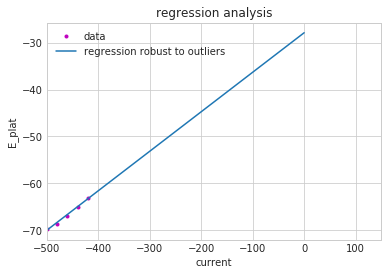

In [73]:
Cell_Features = get_cell_features(df, df_related_features, current_hold)

In [46]:
Cell_Features

Rm (mV)  Input res (MOhm)  tau (ms)  AP threshold (mV)  \
0 -27.871382         84.348492  9.202258         -56.547629   

   AP amplitude (mV)  AP half-width (ms)  AHP (mV)  ADP (mV)      AI (%)  \
0          93.683385                1.32  8.533722       NaN  595.625943   

   MAX freq  rheobase (pA)  sag ratio  
0         8           40.0   1.032866

In [71]:
def cell_features(data_tuple, data_tuple_suppl_info, names):
    """ Analyses a stream of cell dictionaries and outputs all the cell's features in a concatenated DataFrame
    Parameters
    ----------
    data_tuple : tuple of dictionaries of data full of voltage (V) and time (s) traces for different cells
    names : tuple of names of the samples
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Returns
    -------
    All_Cells_Features : DataFrame with values for all required features mentioned in get_cell_features
    """
    All_Cells_Features = pd.DataFrame()
    for (data, data_suppl_info, name) in zip(data_tuple, data_tuple_suppl_info, names):
        print('Processing: ', name)
        # We need the current_hold to calculate the rheobase in get_cell_features
        time, voltage, current, current_hold = data_preparation_asc(data, data_suppl_info)
        filter_ = 8
        if (1/time[1]-time[0]) < 20e3:
            filter_ = (1/(time[1]-time[0]))/(1e3*2)-0.5
        #filter_ = 7
        #if (1/(1e3*time[1] - time[0])) <= 11: # Your sampling frequency is not high enough (if filter_ is like 7 though, it 
        #                                      # should be fine)
        #    filter_ = 4
        #    #filter_ = ((1/time[1]-time[0])/(1e3*2)-0.5 # You devide by 2 to get half the sampling frequency for the filtering one.
        #                                              # Think about the Nyquist theorem
        df, df_related_features = extract_spike_features(time, current, voltage, fil = filter_)
        Cell_Features = get_cell_features(df, df_related_features, current_hold)
        #plt.savefig('../Hippocampus/FiguresRegressionAnalysis/{}.png'.format(name.split('/')[-1].split('.')[0]))
        plt.close()
        All_Cells_Features = pd.concat([All_Cells_Features, Cell_Features], sort = True)
    All_Cells_Features.insert(0, 'name sample', names)
    return All_Cells_Features.fillna(0)       # Nan values can be considered as 0 for AHP, ADP, ... (rheobase??!!)

In [35]:
All_Cells_Features_HC = cell_features(HC, HC_suppl_info, HC_names)

Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s2c4.asc
Rm:  -57.4391967396
Ri:  231.59339127600003
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s2c6.asc
Rm:  -44.697706228720016
Ri:  356.20992342399984
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s5c19.asc
Rm:  -46.698940692
Ri:  349.362692372
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s5c14.asc
Rm:  -8.584873809279998
Ri:  140.721134188
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s5c17.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -44.14958507216
Ri:  308.310173802
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s5c20.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -0.44654926848001253
Ri:  552.9801036799998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s2c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -50.24186229992
Ri:  224.23181960000002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s2c7.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -48.66929422695999
Ri:  219.2252458400001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s6c22.asc
Rm:  -47.978343794560004
Ri:  167.4666940639999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s5c18.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -51.366290153600005
Ri:  262.23914348600005
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s2c8.asc
Rm:  -63.96796518863997
Ri:  322.83200623200025
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s4c12.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -38.32195720832002
Ri:  436.2559816099998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s5c16.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -44.13542069399997
Ri:  301.88825302600014
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s1c2.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.86429738952
Ri:  235.41593590199997
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s4c13.asc
Rm:  -41.625333955760034
Ri:  439.50154756199976
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s2c3.asc
Rm:  -48.89397282568001
Ri:  814.6990983519999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s5c15.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -45.83655124504001
Ri:  139.2145716599999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s1c1.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.68001324896
Ri:  373.333384052
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s2c9.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.89697028544003
Ri:  216.23063028399977
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s6c21.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -50.57297181836002
Ri:  343.30337186199984
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s3c11.asc
Rm:  -66.55071769238
Ri:  130.28929948200002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180801/180801s3c10.asc
Rm:  -21.80810654172
Ri:  241.71113430599996
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180213/180213s1c1fp.asc
Rm:  -56.3485704685075
Ri:  228.14459579249984
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180213/180213s6c1fp.asc
Rm:  -61.9422864608
Ri:  259.819862415
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180213/180213s4c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -46.89723336294998
Ri:  125.29019529750013
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180213/180213s5c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -62.31797325545
Ri:  376.9733278875001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180213/180213s3c1fp.asc
Rm:  -55.71814868132498
Ri:  428.0409257325001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180213/180213s1c2fp.asc
Rm:  -44.8519100186667
Ri:  153.90043622499974
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180828/180828s8c13.asc
Rm:  -51.405232244002
Ri:  418.441513798
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180828/180828s4c08.asc
Rm:  -52.886548863611985
Ri:  246.4865176220001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180828/180828s9c14.asc
Rm:  -35.79175691392
Ri:  356.48493901600006
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180828/180828s1c01.asc
Rm:  -57.061509823839984
Ri:  387.302304334
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180828/180828s4c09.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.26520947612798
Ri:  207.72910439200024
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180828/180828s2c05.asc
Rm:  -62.365727657864
Ri:  187.362705752
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180828/180828s8c12.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -62.506285766480005
Ri:  193.773815984
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180828/180828s6c11.asc
Rm:  -66.00110226940001
Ri:  509.40829795999963
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180828/180828s4c07.asc
Rm:  -42.43546981080001
Ri:  319.7589901519999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180828/180828s2c06.asc
Rm:  -57.394271797647995
Ri:  495.60917438400014
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180828/180828s2c04.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.72407534656
Ri:  247.48661877199996
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180627/180627s2fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.20863858260002
Ri:  309.40155373
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180627/180627s3fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -52.35792202384001
Ri:  455.8014695639999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180627/180627s1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -54.71219821844
Ri:  435.28713927799987
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180627/180627s5fp.asc
Rm:  -62.6325165114
Ri:  199.43137233800007
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180627/180627s4fp.asc
Rm:  -47.064891901519985
Ri:  244.8267870960001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180627/180627s7fp.asc
Rm:  -42.09370467771997
Ri:  577.1268683620003
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180627/180627s6fp.asc
Rm:  -48.98484609003997
Ri:  200.9160067640001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180221/180221s9c2fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -53.71888814325003
Ri:  235.2601715699999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180221/180221s2c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.62910349475
Ri:  155.92781829749987
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180221/180221s8c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -58.760929679975
Ri:  340.2351874875002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180221/180221s4c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -57.1973604415
Ri:  278.76261636000004
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180221/180221s5c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -56.83034775049998
Ri:  239.2919668500001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180221/180221s7c1fp.asc
Rm:  -62.50457655702499
Ri:  431.71683916750004
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180221/180221s3c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -63.76831045035001
Ri:  306.6145898474999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180221/180221s9c1fp.asc
Rm:  -53.5747769126
Ri:  314.63753720999995
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180221/180221s1c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -49.2707426556
Ri:  229.8661104625
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180221/180221s6c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -57.60583730287502
Ri:  270.48490457499975
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s5c28.asc
Rm:  -59.77552595815999
Ri:  224.45013460000013
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s6c30.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -56.52486935664
Ri:  196.79581312
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s4c18.asc
Rm:  -51.00455558592
Ri:  365.85684147600017
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s6c32.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -46.46609226484002
Ri:  367.85510796999984
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s5c24.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.19308800915998
Ri:  182.6512771620002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s4c15.asc
Rm:  -44.49949389584
Ri:  322.2418342480001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s3c10.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.99345781224001
Ri:  236.34189159599998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s2c07.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.36411052400001
Ri:  245.59069519200003
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s4c19.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -54.17587280480001
Ri:  403.86103704599986
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s5c22.asc
Rm:  -57.83653567019999
Ri:  351.77882532999996
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s3c12.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -55.88217316888
Ri:  456.15724805199994
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s5c26.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -33.416537756399975
Ri:  658.0023696000002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s3c13.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.49554708852
Ri:  338.85576865400014
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s2c09.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -55.75288328936
Ri:  360.1410615160002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s3c14.asc
Rm:  -55.158039784319996
Ri:  202.33516679199988
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s6c33.asc
Rm:  -49.31892983056
Ri:  349.778184448
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s6c29.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -50.65334130983999
Ri:  284.83981357200014
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s5c27.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -59.29506181216001
Ri:  179.60289508399987
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s1c01.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.33295212483999
Ri:  182.78125363800024
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s2c04.asc
Rm:  -56.84655887603998
Ri:  441.5907141740002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s5c21.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -59.42196365471999
Ri:  361.4232435060001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s1c03.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -47.26540245776002
Ri:  211.16303686399985
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s2c06.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -58.524218717360014
Ri:  317.08308796799986
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s1c02.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -38.691020088559995
Ri:  101.37617628799997
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s4c16.asc
Rm:  -70.05857553551999
Ri:  300.7763045880001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s5c23.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -54.71880739400002
Ri:  361.1712995319998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s5c20.asc
Rm:  -49.47297566234999
Ri:  327.1705117700003
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s6c31.asc
Rm:  -46.73514897328001
Ri:  229.70678206999992
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s2c05.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.43862918272002
Ri:  148.1377200719999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s3c11.asc
Rm:  -67.28214522068001
Ri:  330.65827142999996
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s4c17.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -31.35205332407999
Ri:  218.04809318800017
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s5c25.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -55.74681907256
Ri:  393.97373537400006
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180809/180809s2c08.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -48.861489702159986
Ri:  424.1605429260001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180124/180124s7c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -55.179897773649984
Ri:  461.7170070025001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180124/180124s4c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.00583252384999
Ri:  442.40765274250003
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180124/180124s1c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -50.1806596972
Ri:  172.77130664499995
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180124/180124s2c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.8803435184
Ri:  259.44220574500014
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180124/180124s5c1fp.asc
Rm:  -42.77033940210811
Ri:  185.9932656864865
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180124/180124s3c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -54.37855120670001
Ri:  130.42919617999996
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180124/180124s6c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -54.7384451013
Ri:  292.68668774500003
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s5c22.asc
Rm:  -47.20977007811997
Ri:  1028.1226613160004
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s4c19.asc
Rm:  -33.033073153199986
Ri:  150.97035038
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s1c01.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -55.53623549583999
Ri:  320.34916189000006
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s5c27.asc
Rm:  -43.29247778029713
Ri:  613.613692867429
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s4c12.asc


/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Rm:  -36.56259232767999
Ri:  331.01025053200004
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s1c04.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.68122779628
Ri:  291.02041846999987
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s1c03.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -35.653120445719985
Ri:  321.60608702600007
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s3c07.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -43.201059103839995
Ri:  229.9929270279999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s4c18.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -53.13744835655999
Ri:  153.8830074540001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s6c33.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -40.685129105360005
Ri:  172.43213077999988
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s5c26.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.59916493872001
Ri:  163.65759398800003
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s3c08.asc
Rm:  -50.3967846844
Ri:  369.70332884000004
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s5c24.asc
Rm:  -57.32651673778522
Ri:  210.6202531838199
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s4c15.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -37.861573556479996
Ri:  97.189525708
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s6c31.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -37.19775388608002
Ri:  311.07003718199985
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s5c23.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -48.618789435120014
Ri:  265.69883300400005
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s4c13.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -51.23461715344001
Ri:  139.2480191059999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s3c09.asc
Rm:  -50.94288231536003
Ri:  225.69912422999968
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s1c02.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.477496818039995
Ri:  323.559090034
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s2c06.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -54.94380917183999
Ri:  161.97453764000002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s4c14.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.40068787416002
Ri:  239.23160327999986
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s2c05.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -58.22940318655999
Ri:  258.48911821200016
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s5c21.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -44.89545569336002
Ri:  90.79855126199982
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s4c16.asc
Rm:  -47.70878346392001
Ri:  305.21721555799985
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s4c17.asc
Rm:  -59.551418467199994
Ri:  153.7762276280001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s5c20.asc
Rm:  -57.37411417272
Ri:  165.29168748800006
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s3c10.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -9.224094108000003
Ri:  129.364782028
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s6c32.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -46.766105399839994
Ri:  231.39402109800008
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s6c29.asc
Rm:  -31.213660938880004
Ri:  418.99535671199993
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s6c30.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.5638155729
Ri:  187.08280771799994
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s3c11.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -56.39478418723999
Ri:  353.6081700700001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s5c25.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -62.637052212
Ri:  331.15385367400006
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180816/180816s5c28.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -24.068462351640015
Ri:  172.84712649399992
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180223/180223s8c1fp.asc
Rm:  -55.8380240101125
Ri:  474.4004518374999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180223/180223s6c2fp.asc
Rm:  -49.076690507105035
Ri:  379.2065530824998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180223/180223s2c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -41.68212967144999
Ri:  499.8661067875
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180223/180223s4c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -56.63013157766252
Ri:  164.47920113749976
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180223/180223s6c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -59.15777497978
Ri:  121.00145474499998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180223/180223s1c2fp.asc
Rm:  -64.37517415311429
Ri:  295.2065754842858
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180223/180223s10c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -28.509235371874993
Ri:  297.37769654749997
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180223/180223s7c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.89866900677853
Ri:  153.23735220428597
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180223/180223s5c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -62.974926942927496
Ri:  148.1016460525
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180223/180223s3c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -62.9187081497
Ri:  270.2206110349999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180223/180223s10c2fp.asc
Rm:  -42.93961230047748
Ri:  120.34907640250006
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180223/180223s4c2fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -59.74940351102499
Ri:  343.77089803250016
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180223/180223s1c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -55.56076143829999
Ri:  212.79147664500024
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180223/180223s9c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -62.601184998874984
Ri:  467.0737203725002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180823/180823s1c06.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -57.96307842771999
Ri:  275.9903135060001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180823/180823s5c19.asc
Rm:  -59.552675057360005
Ri:  285.8677375079999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180823/180823s2c10.asc
Rm:  -62.27147890735999
Ri:  147.1830044160001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180823/180823s3c14.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -36.58945499487999
Ri:  339.9253336060001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180823/180823s3c16.asc
Rm:  -33.19086676292802
Ri:  188.7994963519999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180823/180823s2c09.asc
Rm:  -65.633412932112
Ri:  178.223745272
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180823/180823s1c05.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.96873262416
Ri:  289.10342293800005
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180823/180823s1c04.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -53.79259271235998
Ri:  327.6081423860003
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180823/180823s2c11.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -53.331300786959986
Ri:  462.20730953199995
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180823/180823s3c13.asc
Rm:  -47.02572064016001
Ri:  399.336663594
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180823/180823s5c18.asc
Rm:  -66.99361998340198
Ri:  214.82591268200005
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180823/180823s2c12.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -47.28724377936001
Ri:  361.153480906
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180823/180823s1c03.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.02251565944002
Ri:  247.07750156999998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180823/180823s3c17.asc
Rm:  -57.056459337223984
Ri:  274.236868488
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180823/180823s1c02.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -47.43291603835999
Ri:  374.24714704600007
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180823/180823s1c07.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -53.8175102276
Ri:  216.85055865200005
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180823/180823s2c08.asc
Rm:  -60.3168502464
Ri:  230.62767386400003
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180823/180823s3c15.asc
Rm:  -28.83200209596004
Ri:  101.65638166599986
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180823/180823s1c01.asc
Rm:  -63.58682986332
Ri:  265.24832642600006
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s4c20.asc
Rm:  -56.70012270207997
Ri:  303.39887659600026
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s3c13.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -46.02998481408
Ri:  331.73020571599983
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s1c01.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -40.27669105104003
Ri:  479.9042467359997
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s3c16.asc
Rm:  -40.61809836499999
Ri:  287.64837771000015
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s3c18.asc
Rm:  -46.04567656996
Ri:  396.4913419419999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s5c25.asc
Rm:  -40.26750053080001
Ri:  335.8726581319999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s3c17.asc
Rm:  -46.04894543539997
Ri:  155.62301210400008
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s4c22.asc
Rm:  -40.94716603884004
Ri:  210.46389840599977
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s5c26.asc
Rm:  -38.240755970479974
Ri:  137.21918234200015
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s4c23.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -36.790671269280004
Ri:  427.19248012400004
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s3c15.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -39.24219386059999
Ri:  231.39902184600007
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s1c05.asc
Rm:  -61.06777666143999
Ri:  306.5078375840001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s4c19.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -51.00103445232
Ri:  352.3348007980001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s2c10.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -52.03243587264
Ri:  113.14695874800002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s5c33.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -47.13619251488001
Ri:  410.66694598999993
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s1c02.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.16966727567999
Ri:  945.4107035599999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s5c28.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -57.9044576762
Ri:  205.21500150599996
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s5c31.asc
Rm:  -31.954385203920012
Ri:  328.27495734799993
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s2c06.asc
Rm:  -54.370315143319985
Ri:  161.2618356300002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s5c32.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -36.88214747120001
Ri:  211.3675336559999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s3c12.asc
Rm:  -59.11223384815999
Ri:  202.42413010800004
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s2c09.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -44.437566014880026
Ri:  475.6853389379999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s2c08.asc
Rm:  -49.44882993823999
Ri:  827.9311770880001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s5c30.asc
Rm:  -55.36520882159998
Ri:  212.93504570000005
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s1c03.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -57.946301188519996
Ri:  365.9790009240003
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s3c14.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


A DOWNWARD PEAK WAS OBSERVED GOING TO LESS THAN 200 MV!!!
A DOWNWARD PEAK WAS OBSERVED GOING TO LESS THAN 200 MV!!!
Rm:  -43.20882537775998
Ri:  347.33291168200003
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s4c24.asc
Rm:  -34.26381920368002
Ri:  401.89509277999997
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s5c29.asc
Rm:  -37.187083276800024
Ri:  254.50121477799985
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s4c21.asc
Rm:  -29.370549541119992
Ri:  469.9875013100001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s3c11.asc
Rm:  -52.22115794976001
Ri:  592.939550156
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s1c04.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -63.58784519591999
Ri:  357.16288665600024
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s5c27.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -33.141769124199996
Ri:  99.11858400999998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180818/180818s2c07.asc
Rm:  -48.239167054800006
Ri:  411.34532950399995
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s3c15.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -54.14772476976002
Ri:  458.1903329519998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s2c12.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.53933948512
Ri:  110.43242224000014
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s1c04.asc
Rm:  -58.84340363752
Ri:  400.4781170040002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s3c19.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -50.27243234075999
Ri:  396.86932037199995
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s5c29.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -53.02387039447998
Ri:  321.46560901600026
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s2c11.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.68892670812
Ri:  353.823417886
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s4c27.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -57.73079867268002
Ri:  228.5011839319995
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s3c16.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -58.28940557167999
Ri:  293.17041092799985
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s3c17.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -47.603497933960014
Ri:  617.4976015079998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s1c03.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -63.73321846848
Ri:  310.2202901200001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s3c25.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -59.54743992284002
Ri:  332.2044697959997
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s3c24.asc
Rm:  -54.965274048880005
Ri:  452.4376661359998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s5c28.asc
Rm:  -23.576033366319976
Ri:  321.2808077600002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s3c18.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.48705417076
Ri:  365.507483972
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s2c07.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -47.34365297233485
Ri:  164.1623005151003
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s5c33.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -55.501749294439996
Ri:  220.83108756400023
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s5c30.asc
Rm:  -44.51894183391997
Ri:  197.7937923440004
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s2c09.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -59.01749271028
Ri:  406.108436862
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s2c08.asc
Rm:  -58.113544617680006
Ri:  378.3881585539998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s3c23.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -57.17212324424
Ri:  366.0994099119998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s2c06.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.33643432684
Ri:  666.397389756
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s4c26.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -56.63589159391999
Ri:  433.6883629759999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s2c05.asc
Rm:  -56.60821374640002
Ri:  162.87367293199983
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s5c31.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.256313619160004
Ri:  379.59406976399987
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s3c20.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -57.15759764212
Ri:  386.88580825199995
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s1c01.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -28.836539704639993
Ri:  192.68956121600004
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s2c10.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.42007573583999
Ri:  221.33523428400002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s5c32.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -55.35914920748
Ri:  458.5665717319997
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s3c14.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -47.49056393743999
Ri:  225.98182918400016
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s3c21.asc
Rm:  -66.57168187084
Ri:  721.4239553240006
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s1c02.asc
Rm:  -58.25091556415999
Ri:  291.47110954000027
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s3c22.asc
Rm:  -65.51301023604
Ri:  180.67908193199972
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180911/180911s3c13.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -50.76951994372002
Ri:  388.8026119799996
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180116/180116s3c1fp2.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.43242854057497
Ri:  419.20396375250016
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180116/180116s6c1fp.asc
Rm:  -50.30895593955
Ri:  319.12262296499995
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180116/180116s2c1fp1.asc
Rm:  -52.613360299187505
Ri:  162.83017246250003
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180116/180116s7c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -63.645082394550016
Ri:  291.79636338750004
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180116/180116s4c1fp1.asc
Rm:  -65.4749142906
Ri:  351.41057822500005
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180116/180116s1c1fp1.asc
Rm:  -57.541154251274996
Ri:  396.5800609225
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180116/180116s8c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -54.07142799440001
Ri:  170.615878805
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180116/180116s5c1fp.asc
Rm:  -65.05482705648501
Ri:  308.74160166499996
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s5c13.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -54.427921058879996
Ri:  240.3680552160001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s7c25.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -43.69930208671995
Ri:  276.19543512200016
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s1c01.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -57.09502962312
Ri:  320.797290574
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s1c03.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -43.52866401011997
Ri:  211.69150151000014
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s9c32.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -43.27057899264002
Ri:  181.34871496799988
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s1c02.asc
Rm:  -58.089170152160015
Ri:  314.4580156959999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s4c07.asc
Rm:  -46.2684974456
Ri:  214.44129874
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s8c29.asc
Rm:  -43.214111378640034
Ri:  204.26347665199978
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s7c26.asc
Rm:  -120.37985858053327
Ri:  -185.38869607999973
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s2c04.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -57.65935042792002
Ri:  236.92812459599992
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s5c14.asc
Rm:  -53.577891825999984
Ri:  206.2359246760001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s9c30.asc
Rm:  -48.77103484908001
Ri:  122.08117211599998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s4c10.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -46.15441584727998
Ri:  154.70324508800013
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s9c31.asc
Rm:  -55.18883626844
Ri:  196.85945543399995
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s7c22.asc
Rm:  -44.96616400104
Ri:  332.9588763620001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s8c28.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -30.257496635039963
Ri:  341.1978226600002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s4c08.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -54.48587866555997
Ri:  358.9804780780002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s6c20.asc
Rm:  -40.621569464820006
Ri:  439.89734945799995
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s7c23.asc
Rm:  -25.580949325508563
Ri:  410.57630844457145
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s2c05.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -53.756162613520004
Ri:  197.93339121399998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s7c24.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -36.502977734160005
Ri:  393.84657460399995
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s5c16.asc
Rm:  -52.54668208555997
Ri:  359.0519972660002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s4c09.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -46.135967746320006
Ri:  751.1074291440001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s5c12.asc
Rm:  -55.8414790600343
Ri:  527.1146725108568
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s5c17.asc
Rm:  -28.555828564479988
Ri:  322.8291286880001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s6c21.asc
Rm:  -32.62812290504001
Ri:  528.8219814759999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s6c18.asc
Rm:  -42.74801211511999
Ri:  461.8261333480001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s5c11.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -45.71710910704
Ri:  183.86775543599998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s3c06.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -74.81980969028
Ri:  233.98983479400005
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s6c19.asc
Rm:  -24.202673818200005
Ri:  159.43261577799996
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s9c33.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -34.54302284656001
Ri:  261.73249441
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180804/180804s8c27.asc
Rm:  -24.136315664279955
Ri:  72.82984485400009
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s1c7.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.63972874503999
Ri:  242.10075021999995
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s4c19.asc
Rm:  -42.79301423312003
Ri:  153.44575894999977
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s2c10.asc
Rm:  -27.871381983640035
Ri:  84.34849199799993
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s1c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -50.79219415400001
Ri:  399.30846769199997
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s3c16.asc
Rm:  -55.004552982
Ri:  316.1520064880001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s1c3.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -58.79442438823999
Ri:  217.219289168
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s1c6.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.00988932544
Ri:  220.2356663240001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s4c21.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.25883515968
Ri:  300.1195528679999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s3c17.asc
Rm:  -36.93007852675998
Ri:  198.08837813200017
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s2c11.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -30.235672063520013
Ri:  231.36701538799997
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s3c15.asc
Rm:  -27.163997793520025
Ri:  308.328929676
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s5c25.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -46.740327982720004
Ri:  260.14409756399994
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s1c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -32.21765274527999
Ri:  448.53672785599997
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s4c23.asc
Rm:  -53.45606549891998
Ri:  197.86943651000016
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s4c22.asc
Rm:  -17.864566697039933
Ri:  183.01100784800025
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s6c30.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -49.54161698888002
Ri:  322.13586341199994
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s6c27.asc
Rm:  -32.51070526920004
Ri:  148.99534244399985
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s2c9.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -50.621249319960015
Ri:  146.3979043059999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s2c13.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -44.022023019600006
Ri:  285.587781276
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s4c20.asc
Rm:  -64.43740241632
Ri:  240.48121498800018
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s5c26.asc
Rm:  -53.62827181439998
Ri:  225.70643495200022
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s1c2.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -57.07587265183999
Ri:  417.91060806800004
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s3c14.asc
Rm:  -48.1036760195846
Ri:  129.10705849923085
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s2c8.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -32.57679949496001
Ri:  390.73435859599994
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s3c18.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -40.37042041676
Ri:  312.74846005800015
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s6c28.asc
Rm:  -57.73068104308
Ri:  276.09484509
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s5c24.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -50.31783412088
Ri:  379.906911302
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s2c12.asc
Rm:  -17.557890016941926
Ri:  137.5270196260002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s6c29.asc
Rm:  -45.79198449451997
Ri:  300.8750830180002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180730/180730s1c1.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -59.740865904079996
Ri:  130.50298612199995
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180908/180908s2c14.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -40.332003073239996
Ri:  132.98820609800003
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180908/180908s2c10.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -55.47560543891999
Ri:  323.85817741400007
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180908/180908s2c12.asc
Rm:  -39.23740641332
Ri:  270.20069493799997
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180908/180908s2c11.asc
Rm:  -33.84085686367998
Ri:  216.9604645300002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180908/180908s2c16.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -29.873136022080004
Ri:  373.5335056960001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180908/180908s2c15.asc
Rm:  -38.30087475428001
Ri:  356.80278214599986
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180908/180908s2c13.asc
Rm:  -59.127498099080015
Ri:  276.24238699000006
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180908/180908s1c04.asc
Rm:  -57.72499709548
Ri:  441.2651825900001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180908/180908s1c07.asc
Rm:  -40.263259369560004
Ri:  380.0844632219999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180908/180908s1c02.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -47.640973385679985
Ri:  130.15526396000007
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180908/180908s1c06.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -40.0088432088
Ri:  300.65045567999994
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180908/180908s2c08.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -11.716067041520006
Ri:  300.4317681239999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180908/180908s1c01.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -63.66425231527999
Ri:  279.62136439200015
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180908/180908s1c05.asc
Rm:  -52.23022919547999
Ri:  205.836683046
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180908/180908s1c03.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -55.985333226
Ri:  312.0197469000001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180908/180908s2c09.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -46.89779359552
Ri:  370.66804773999996
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180314/180314s7c2fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -43.743057805400035
Ri:  129.8551874024998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180314/180314s7c7fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.81759112977248
Ri:  224.4832479425
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180314/180314s5c2fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -51.66318860044999
Ri:  73.0974226875
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180314/180314s1c2fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.65939443071498
Ri:  201.78047368500017
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180314/180314s6c7fp.asc
Rm:  -50.68577729524249
Ri:  301.7680153975001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180314/180314s6c2fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -59.99677264323998
Ri:  167.57455186000024
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180314/180314s1c7fp.asc
Rm:  -66.62885039445
Ri:  397.27273084499996
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180314/180314s4c2fp.asc
Rm:  -43.46866351920501
Ri:  175.22356210499996
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180314/180314s2c7fp.asc
Rm:  -60.614867968200016
Ri:  145.20728402499992
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180314/180314s2c2fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -54.02490767413751
Ri:  218.9097346625
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180314/180314s3c2fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -49.65105466150002
Ri:  268.35460212499976
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180314/180314s3c7fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.6671000357
Ri:  392.1951138125
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s2c07.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -53.18437681304002
Ri:  287.15042187399985
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s4c20.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -21.436376474720007
Ri:  412.07097670200005
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s4c13.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -59.84402228864001
Ri:  130.27104320799984
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s3c11.asc
Rm:  -32.06754298224
Ri:  415.4120710240001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s6c29.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -40.80724214231999
Ri:  180.21469631600004
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s3c12.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -49.884396154640015
Ri:  354.645719098
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s2c08.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -56.14926084188001
Ri:  205.41099333399984
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s4c14.asc
Rm:  -51.94681356239998
Ri:  130.4377169240001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s1c02.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -47.63647009220001
Ri:  110.89661841400007
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s7c33.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -52.44609032407999
Ri:  174.384885964
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s6c30.asc
Rm:  -26.10943974816
Ri:  289.9127213
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s3c10.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -52.18314721184
Ri:  290.05969781400006
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s4c15.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -46.65084205576
Ri:  320.45687863000006
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s5c21.asc
Rm:  14.70718369904003
Ri:  173.3602750520001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s5c25.asc
Rm:  -18.083240419440052
Ri:  205.66749708685688
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s5c24.asc
Rm:  -53.724764466519986
Ri:  436.60058612400013
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s2c05.asc
Rm:  -67.88101868172004
Ri:  116.06861775599991
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s5c23.asc
Rm:  -55.48126222051999
Ri:  175.3856731620001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s4c18.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -36.789420516800014
Ri:  188.75948592199987
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s5c22.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -39.03282280512001
Ri:  119.95562017799998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s1c01.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -78.34535825712
Ri:  242.69423356400006
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s7c32.asc
Rm:  -25.799325073520002
Ri:  285.206857336
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s3c09.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -42.229831662519985
Ri:  250.09781258600006
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s4c17.asc
Rm:  2.827804021279995
Ri:  238.92132624000004
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s7c31.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -36.588874956119966
Ri:  447.6939219020002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s2c06.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -38.765920812719976
Ri:  287.8890708160002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s4c19.asc
Rm:  -37.21378236955998
Ri:  225.23154889000017
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s5c27.asc
Rm:  -47.08810739671999
Ri:  347.004131528
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s1c03.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -51.13020690092
Ri:  521.2467253640001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s6c28.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -30.672379053199982
Ri:  311.47171432400006
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s2c04.asc
Rm:  -56.804105383919975
Ri:  131.94171460000004
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s5c26.asc
Rm:  -27.694197464320006
Ri:  276.20218823600004
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180807/180807s4c16.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -43.659835995279984
Ri:  299.4713615220001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180724/180724c15.asc
Rm:  -48.23262029424003
Ri:  326.2876922019999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180724/180724c24.asc
Rm:  -59.69439936238
Ri:  89.33581256600002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180724/180724c29.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.17530323603998
Ri:  286.0189003780002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180724/180724c21.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.55080067387999
Ri:  212.76731337799995
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180724/180724c09.asc
Rm:  -69.83046951472
Ri:  237.97799084
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180724/180724c26.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -47.524123834040005
Ri:  402.7539654340001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180724/180724c14.asc
A DOWNWARD PEAK WAS OBSERVED GOING TO LESS THAN 200 MV!!!
A DOWNWARD PEAK WAS OBSERVED GOING TO LESS THAN 200 MV!!!


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  10.205837271299984
Ri:  1253.403412272
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180724/180724c18.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.90437743976
Ri:  266.8121559759998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180724/180724c10.asc
Rm:  -52.42662223839998
Ri:  270.9203455360001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180724/180724c01.asc
Rm:  -45.071588404680014
Ri:  341.51822961799985
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180724/180724c22.asc
Rm:  -48.27309172311998
Ri:  466.76894730800007
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180724/180724c16.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -48.99611607752
Ri:  592.165331922
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180724/180724c13.asc
Rm:  -52.885786473120014
Ri:  345.7457068479999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180724/180724c28.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -52.83670817816001
Ri:  344.5954390559999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180724/180724c17.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -54.324105818599996
Ri:  272.2687965340001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180724/180724c12.asc
Rm:  -62.60305238124002
Ri:  245.2492835739998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180724/180724c05.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -55.46617037795999
Ri:  318.83797241800016
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180724/180724c08.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -56.86023777487999
Ri:  383.627926832
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180724/180724c30.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -54.81739216288
Ri:  345.176792118
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180724/180724c19.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -62.325358270720024
Ri:  250.90223326799986
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180724/180724c02.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -4.974221068171431
Ri:  579.2645201157143
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180724/180724c06.asc
Rm:  -57.91431452280001
Ri:  593.1376681339998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180724/180724c04.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -62.630097849039984
Ri:  257.2190620260001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180724/180724c07.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -71.25483588556
Ri:  255.52313544600014
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180724/180724c27.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -34.93839451920001
Ri:  311.97811206599994
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180724/180724c11.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -49.97606006312
Ri:  379.51292310199983
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180724/180724c03.asc
Rm:  -60.528108840239994
Ri:  555.2024990599998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180724/180724c23.asc
Rm:  -37.62375617175998
Ri:  630.8872926720001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180724/180724c20.asc
Rm:  -58.491298914639984
Ri:  305.4457825640001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180724/180724c25.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -35.78336185219999
Ri:  333.9662298780001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s2c09.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -53.3483943584
Ri:  385.161558812
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s5c23.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -47.496652154799996
Ri:  189.59441326200007
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s5c22.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -49.37936460207999
Ri:  358.06896340000026
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s5c25.asc
Rm:  -46.16484366216
Ri:  238.38317103399996
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s6c33.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -53.28314802871998
Ri:  276.46432501000015
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s5c30.asc
Rm:  -66.41946903313999
Ri:  56.45822764800001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s5c28.asc
Rm:  -62.79465788495996
Ri:  211.60153920400015
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s2c07.asc
Rm:  -43.56122212847999
Ri:  417.556628622
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s4c20.asc
Rm:  -38.58568079228
Ri:  438.00211531800005
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s5c26.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -44.66512320295999
Ri:  223.95605376000006
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s5c29.asc
Rm:  -45.21713429087997
Ri:  868.2017159120006
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s1c04.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -37.035521958719976
Ri:  260.31714895200014
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s2c11.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -47.12537122689601
Ri:  239.00366310399988
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s3c13.asc
Rm:  -57.586474376640005
Ri:  134.17223714200003
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s3c14.asc
Rm:  -50.62870919072
Ri:  309.574227148
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s2c05.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -56.68575608308
Ri:  112.36454463799996
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s6c32.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -39.08383511184001
Ri:  496.16096011999986
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s3c12.asc
Rm:  -46.340304561359986
Ri:  422.42110004
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s5c27.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -59.87420582447999
Ri:  319.097235204
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s4c21.asc
Rm:  -131.11981512346662
Ri:  -132.4005360299999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s2c08.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -49.43227748823999
Ri:  213.11616513600006
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s4c17.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -32.5374989964
Ri:  283.602831676
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s5c24.asc
Rm:  -33.44311661752
Ri:  81.03190738999997
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s5c31.asc
Rm:  -37.63278117280002
Ri:  609.2105784959998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s3c15.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -55.514680570079996
Ri:  158.683149092
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s4c18.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -35.111923621839985
Ri:  156.34309585600008
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s1c01.asc
Rm:  -59.74271393160001
Ri:  251.188129536
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s1c03.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.49712639939999
Ri:  270.9134046400001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s4c19.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.47430084327996
Ri:  221.23432862000018
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s2c10.asc
Rm:  -44.42574750279999
Ri:  272.1542645960001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s3c16.asc
Rm:  -39.20442527824001
Ri:  262.88026539599997
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s2c06.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -59.130239280599994
Ri:  290.8556164900001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180813/180813s1c02.asc
Rm:  -67.02793775952001
Ri:  223.65646711599993
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180906/180906s3c17.asc
Rm:  -57.49910160835999
Ri:  241.99821843400022
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180906/180906s1c01.asc
Rm:  -60.119715558679985
Ri:  545.8658554120002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180906/180906s1c04.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -43.62050028291999
Ri:  440.5412898460001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180906/180906s2c13.asc
Rm:  -59.76837638336
Ri:  235.27864652399995
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180906/180906s1c05.asc
Rm:  -50.23420613676
Ri:  342.94939454199994
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180906/180906s3c19.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -39.095447278480016
Ri:  331.017189812
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180906/180906s5c24.asc
Rm:  -41.68236309263999
Ri:  448.55160453600007
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180906/180906s1c07.asc
Rm:  -42.453418818639996
Ri:  434.89708813400006
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180906/180906s3c18.asc
Rm:  -57.320586173000024
Ri:  246.12610025799987
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180906/180906s1c09.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -42.71559459904002
Ri:  274.87223995999994
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180906/180906s1c02.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -59.44919396748
Ri:  282.25725289800016
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180906/180906s2c11.asc
Rm:  -57.306759634839985
Ri:  92.98474462600014
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180906/180906s3c22.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -57.79943729119999
Ri:  367.1041419840001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180906/180906s3c16.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -62.51942830959999
Ri:  282.3620320960001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180906/180906s1c03.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.04542648192
Ri:  406.38932659599993
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180906/180906s2c15.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -52.68587370447999
Ri:  344.8794554520002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180906/180906s4c23.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -57.35558988464
Ri:  318.24993005599987
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180906/180906s3c20.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.6674133242
Ri:  211.86505234599989
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180906/180906s2c12.asc
Rm:  -57.203893485280005
Ri:  350.94702630999996
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180906/180906s2c10.asc
Rm:  -50.18177611928
Ri:  229.29272334000004
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180906/180906s2c14.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -38.331486214759984
Ri:  383.53677465800024
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180906/180906s1c06.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.68531440028001
Ri:  320.59298243000006
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180906/180906s3c21.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.34081716964
Ri:  234.69010076600006
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180906/180906s1c08.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -57.5875646378
Ri:  171.00915717399994
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180110/180110s1c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -53.721467741599994
Ri:  186.315292605
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180110/180110s6c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.29764543805001
Ri:  326.38375062250003
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180110/180110s3c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -55.66389592969999
Ri:  164.57524667
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180110/180110s5c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -54.809576221809984
Ri:  159.9950928650001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180110/180110s7c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -43.197829020925
Ri:  469.01850308250005
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180110/180110s8c1fp.asc
Rm:  -57.29384787831499
Ri:  301.79733520249994
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180110/180110s4c1fpr1.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -57.4141328915
Ri:  220.29716675
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180110/180110s2c1fp.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -59.718715628
Ri:  308.9140065949998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180718/180718c17.asc
Rm:  -67.89125037995001
Ri:  191.74585271
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180718/180718c28.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.266890994784
Ri:  360.4217688659999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180718/180718c19.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


A DOWNWARD PEAK WAS OBSERVED GOING TO LESS THAN 200 MV!!!
A DOWNWARD PEAK WAS OBSERVED GOING TO LESS THAN 200 MV!!!
Rm:  -51.95480089479999
Ri:  106.2936607760001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180718/180718c13.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.83476851329199
Ri:  267.0142736980002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180718/180718c06.asc
Rm:  -71.22876617736199
Ri:  220.50611615800014
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180718/180718c11.asc
Rm:  -47.86752285107998
Ri:  416.0055577500002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180718/180718c26.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.10362566096
Ri:  247.42891903800012
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180718/180718c12.asc
Rm:  -63.53759802648
Ri:  376.54931489599994
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180718/180718c05.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -47.26382321040004
Ri:  276.62643522399964
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180718/180718c20.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.57237544171998
Ri:  226.00083127399998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180718/180718c27.asc
Rm:  -42.024689661640004
Ri:  558.79597455
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180718/180718c04.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -48.52676535559997
Ri:  342.95945932200016
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180718/180718c15.asc
Rm:  -63.879836114480014
Ri:  217.54544673999993
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180718/180718c29.asc
Rm:  -54.2969190132
Ri:  379.350938892
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180718/180718c30.asc
Rm:  -62.74110989016001
Ri:  249.54815470000008
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180718/180718c01.asc
Rm:  -61.72131663368799
Ri:  410.5372285660001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180718/180718c08.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -52.268113122740004
Ri:  208.17267206799994
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180718/180718c25.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -46.21474097779999
Ri:  219.22149365799999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180718/180718c03.asc
Rm:  -68.58870337004001
Ri:  236.57052411399997
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180718/180718c23.asc
Rm:  -11.562463726840008
Ri:  79.86775864599998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180718/180718c14.asc
Rm:  -47.31439282554995
Ri:  484.89019459000025
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180718/180718c07.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -54.79187199905398
Ri:  144.0839840540001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180718/180718c21.asc
Rm:  -57.204633773199994
Ri:  355.8275629220001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180718/180718c02.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -30.806862077955984
Ri:  202.36780146200007
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180718/180718c24.asc
Rm:  -55.11401463911999
Ri:  431.3613752480001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180718/180718c16.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -49.375390969279984
Ri:  124.55795332600003
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180718/180718c10.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -54.19716519506001
Ri:  110.56658651
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180718/180718c22.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.7284691398
Ri:  196.0405320620001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180718/180718c09.asc
Rm:  -61.338843485200016
Ri:  340.4047233019998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Patch-seq/180718/180718c18.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -54.11328718468001
Ri:  405.033751342
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171113/171113s4c6.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -56.20932818310001
Ri:  267.4245571449999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171113/171113s3c8.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -54.701654970350006
Ri:  332.1438995275001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171113/171113s5c8.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -54.28460018815001
Ri:  270.70051956749995
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171113/171113s2c5.asc
Rm:  -52.211061329699994
Ri:  414.2014803200002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171113/171113s5c3.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -54.35084203694999
Ri:  216.3834789475
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171113/171113s4c8.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -51.03112492689999
Ri:  265.67292534
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171113/171113s4c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -57.403687514400005
Ri:  145.64339157000012
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170719/170719s1c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -56.92661629340003
Ri:  398.8613591099998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170526/170526s2c3.asc
Rm:  -65.84817066880002
Ri:  306.657748225
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170526/170526s1c5.asc
Rm:  -66.1526345542
Ri:  284.89265762499997
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170703/170703s3c7.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.05505098395001
Ri:  317.45161434749986
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170703/170703s2c8.asc
Rm:  -73.09674340790001
Ri:  236.64462849499995
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170703/170703s3c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -53.76361114019998
Ri:  485.84573675000007
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170703/170703s1c9.asc
Rm:  -67.0207287032
Ri:  177.44975196500002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170421/170421s6c3.asc
Rm:  -62.42367356775
Ri:  359.5423102774999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170421/170421s4c4.asc
Rm:  -70.81227897375003
Ri:  259.2813702574998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170421/170421s3c5.asc
Rm:  -64.54025705749999
Ri:  260.03055932500024
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170717/170717s2c9.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.74041214199998
Ri:  126.66162262000013
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170621/170621s2c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -55.226465199100005
Ri:  259.0463661649998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170621/170621s2c9.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -71.97317365820001
Ri:  203.10353885999967
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170621/170621s1c9.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -62.79136664290001
Ri:  251.82649804499997
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170621/170621s3c9.asc
Rm:  -66.68714917119998
Ri:  295.3872879300002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170606/170606s1c8.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.76707723149998
Ri:  286.5275381674999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170606/170606s1c6.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -58.1462125586
Ri:  197.21627309500002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170606/170606s1c9.asc
Rm:  -61.692588975519975
Ri:  404.9510306020001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171018/171018s2c8.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -71.6320126161
Ri:  316.9335497399999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171018/171018s4c4.asc
Rm:  -53.81654343554998
Ri:  341.11964865250013
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171018/171018s3c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -57.98896892474998
Ri:  316.7631970575001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171018/171018s3c5.asc
Rm:  -60.297858668149985
Ri:  389.9488273375001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171018/171018s2c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.05778615359998
Ri:  113.99365641500029
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171018/171018s4c8.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.7969529498
Ri:  286.35384910000016
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171220/171220s3c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.303387668
Ri:  189.55290344999995
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171220/171220s2c6.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.33818994655002
Ri:  457.7347155625
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171220/171220s3c6.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.93565124860002
Ri:  111.76090731999984
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171220/171220s2c7.asc
Rm:  -68.8226766293
Ri:  226.6758868400001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171220/171220s3c5.asc
Rm:  -59.081192303899996
Ri:  209.05345651
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170503/170503s3c4.asc
Rm:  -59.396800510300004
Ri:  284.71931605249995
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170503/170503s1c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.222302522939984
Ri:  161.35672476000008
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170503/170503s1c3.asc
Rm:  -62.49753431299997
Ri:  173.4504797325003
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170503/170503s2c6.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -47.863371415674976
Ri:  282.16635642500023
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170503/170503s1c6.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.7056153656
Ri:  171.90394246999992
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170509/170509s4c4.asc
Rm:  -59.92324844794999
Ri:  422.9552738024999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170509/170509s3c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -51.10242127930002
Ri:  289.4134798825
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170509/170509s1c6.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.84836486200002
Ri:  215.00314051749987
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170509/170509s1c4.asc
Rm:  -54.03313299460002
Ri:  422.13805187999975
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170509/170509s2c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -51.4481472183
Ri:  405.8631310075
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170509/170509s1c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.25976432510001
Ri:  295.44168492749986
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170509/170509s5c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.406027023275016
Ri:  93.53045196749991
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170508/170508s4c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.4643623716
Ri:  222.87602982749996
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170508/170508s2c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.507131251000004
Ri:  263.93130147500005
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170508/170508s1c6.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -54.43340593110001
Ri:  390.6250549849999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170508/170508s3c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -71.29068072900002
Ri:  403.7228588249998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170508/170508s3c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.56472128855
Ri:  315.79922634249976
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171226/171226s3c3.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.303182918649995
Ri:  161.6959377874998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171226/171226s3c5.asc
Rm:  -72.516517545
Ri:  246.6328692949999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171226/171226s3c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -55.956782293899984
Ri:  368.80612297500016
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171221/171221s5c5.asc
Rm:  -53.503154117099974
Ri:  132.91841076750006
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171002/171002s4c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.4184358979
Ri:  246.50735151500007
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171002/171002s6c8.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -63.338248738999994
Ri:  419.45416508500017
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171002/171002s3c6.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.1827822095
Ri:  258.93871933
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171002/171002s3c4.asc
Rm:  -59.267438663650026
Ri:  461.69906720499966
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171002/171002s3c8.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.30140455865
Ri:  348.2276226824999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171002/171002s5c8.asc
Rm:  -68.70779571545
Ri:  105.41423294250002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171002/171002s6c6.asc
Rm:  -65.60169565345002
Ri:  239.62560418749987
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171002/171002s4c8.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -63.79726545464999
Ri:  233.82417265750013
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170524/170524s2c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -39.72921738365001
Ri:  283.6473609049999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170524/170524s2c6.asc
Rm:  -61.94562494099999
Ri:  85.62564383000002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170524/170524s1c4.asc
Rm:  -62.58663612949998
Ri:  125.68805591750012
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170630/170630s1c5.asc
Rm:  -60.07000794780001
Ri:  280.363856705
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170630/170630s3c8.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.7527662056
Ri:  265.73085222000014
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170630/170630s1c9.asc
Rm:  -67.62187290780001
Ri:  422.3637867999999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170630/170630s2c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -63.1974871097
Ri:  104.88070122499995
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170630/170630s4c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.99181612039999
Ri:  262.2198837699999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170630/170630s3c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.42601057760001
Ri:  224.13953540000009
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170505/170505s2c5.asc
Rm:  -41.073007848399996
Ri:  266.7256901200001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170505/170505s4c4.asc
Rm:  -71.71420830084999
Ri:  333.58008105750014
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170505/170505s2c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.18419281450002
Ri:  223.60105103249992
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170505/170505s2c6.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.69925799799999
Ri:  216.63767027249995
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170505/170505s5c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -46.806242177299985
Ri:  417.0179210300001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170505/170505s3c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -62.468818295600016
Ri:  193.39199374999976
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170426/170426s3c4.asc
Rm:  -64.51927555725
Ri:  339.80132405250004
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170426/170426s3c5.asc
Rm:  -59.231525587200004
Ri:  255.4398228325
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170426/170426s2c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -54.72090747879999
Ri:  364.26855932000024
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170927/170927s4c7.asc
Rm:  -56.72694805215
Ri:  314.0929709674998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170927/170927s3c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -57.1258376607
Ri:  253.92143742000007
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170927/170927s4c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -59.02023380509998
Ri:  279.75821888500025
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170927/170927s1c8.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -51.521382245449985
Ri:  290.4972873025002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170927/170927s4c2.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -62.95546101229999
Ri:  324.64239071499986
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170927/170927s1c4.asc
Rm:  -50.95808806690002
Ri:  293.3286584099999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170927/170927s1c6.asc
Rm:  -47.45231378119998
Ri:  529.9781296000002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170614/170614s1c4.asc
Rm:  -59.17515616739999
Ri:  240.07187051500014
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170906/170906s3c8.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -62.270447286300005
Ri:  146.8078952549998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170906/170906s1c10.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.18390432359996
Ri:  166.73665897000032
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170906/170906s2c8.asc
Rm:  -61.47723522220002
Ri:  348.48885818999975
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170906/170906s1c8.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -52.10227965179999
Ri:  337.81106303
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170814/170814s1c3.asc
Rm:  -48.95418239989999
Ri:  389.94164950499993
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170814/170814s3c7.asc
Rm:  -58.04917052469998
Ri:  331.3093379850002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170814/170814s3c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -62.09458676540001
Ri:  257.35339911
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170914/170914s1c8.asc
Rm:  -62.0874984026
Ri:  182.72778597999996
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170914/170914s3c10.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.20665761210002
Ri:  158.05945442499976
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170914/170914s3c2.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -55.41663220440003
Ri:  129.1136453799998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170914/170914s4c6.asc
Rm:  -33.655312925400054
Ri:  275.44522020499977
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170626/170626s2c9.asc
Rm:  -65.848596728
Ri:  277.21158912500016
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170626/170626s1c9.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.108490034
Ri:  62.46698468500007
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170626/170626s2c5.asc
Rm:  -70.9043022464
Ri:  283.3145014900002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170626/170626s4c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -63.2185437113
Ri:  222.22424313500002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170626/170626s3c9.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.4003759222
Ri:  100.5550852
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170626/170626s3c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.24171360579999
Ri:  270.2972767750002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171016/171016s2c9.asc
Rm:  -60.10557263409997
Ri:  289.62638903500033
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171016/171016s3c6.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.7657710272
Ri:  290.50396159999997
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171016/171016s2c6.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.79752553600001
Ri:  330.3335540099999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171016/171016s3c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.961281363
Ri:  291.05980368999997
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171016/171016s4c8.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -41.17311600430003
Ri:  161.98698129999985
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171016/171016s4c5.asc
Rm:  -59.39477661475
Ri:  220.7466107125001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171016/171016s3c8.asc
Rm:  -62.01155089229998
Ri:  282.3507225650002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170628/170628s2c7.asc
Rm:  -34.95864321720002
Ri:  260.78174386999996
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170628/170628s2c4.asc
Rm:  -51.005409502899994
Ri:  282.200879545
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170530/170530s3c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.44753435115
Ri:  358.8307945275
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170530/170530s3c4.asc
Rm:  -46.21152450509999
Ri:  247.63396150000005
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170530/170530s1c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.76478226569999
Ri:  225.48296308000013
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170418/170418s2c4.asc
Rm:  -75.9082531499
Ri:  325.78685776749995
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170418/170418s6c6.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -62.53355654455001
Ri:  410.78291812250006
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170925/1709251s3c4.asc
Rm:  -64.65961485224997
Ri:  298.8792924975004
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170925/1709251s3c8.asc
Rm:  -74.3359576995
Ri:  344.34893324499984
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170925/1709251s2c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.04291072960001
Ri:  251.53731714000017
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170925/1709251s2c6.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -59.07557721430001
Ri:  180.08417592499987
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170925/1709251s1c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.33050100554999
Ri:  333.7027493475001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170925/1709251s1c6.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.14199733385
Ri:  206.76224489749987
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170925/1709251s3c6.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -79.97699441154998
Ri:  176.5972220075001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170511/170511s2c5.asc
Rm:  -60.80402062039998
Ri:  252.65341095500017
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170511/170511s1c6.asc
Rm:  -55.77957842410001
Ri:  238.8710797049999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170511/170511s1c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -56.25580871199998
Ri:  239.72588627500008
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170511/170511s3c3.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -63.74236185720001
Ri:  322.8917701924999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170511/170511s3c6.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.2409175208
Ri:  291.66088448250025
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170511/170511s2c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -59.50998539049998
Ri:  343.5261111275002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170501/170501s5c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -53.403574701825
Ri:  141.17558168750003
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170501/170501s1c5.asc
Rm:  -57.95240697770002
Ri:  140.21469614499998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170501/170501s2c7.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -47.636808959399985
Ri:  389.7265668700001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170427/170427s5c5.asc
Rm:  -67.65975098180002
Ri:  168.88713228999993
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170427/170427s1c5.asc
Rm:  -59.2440788597
Ri:  261.5074438700001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170721/170721s1c10.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -59.81151184240002
Ri:  307.30990619999983
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170424/170424s6c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.239674931
Ri:  296.889790375
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170424/170424s6c2.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -48.74888493819998
Ri:  262.0261308975001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170424/170424s2c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.340534587549996
Ri:  161.3847794675
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170424/170424s2c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.42524362145002
Ri:  363.7623761374996
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170707/170707s3c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.97276662359998
Ri:  189.54122059000017
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170707/170707s2c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.60900487579998
Ri:  344.08485343
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170707/170707s2c7.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -56.588305600400005
Ri:  450.489570045
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170707/170707s1c3.asc
Rm:  -61.68523136000001
Ri:  351.31690105999985
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170707/170707s1c5.asc
Rm:  -55.5209068586
Ri:  450.31308800500017
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170331/170331s4c3.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.23242369649998
Ri:  282.30534790625006
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170331/170331s1c3.asc
Rm:  -60.11554811983335
Ri:  399.1339309249999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170331/170331s4c5.asc
Rm:  -66.24883029655
Ri:  329.0616241275001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170921/170921s1c3.asc
Rm:  -48.24550623805
Ri:  349.96376800749994
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170921/170921s3c4.asc
Rm:  -32.64460251580001
Ri:  175.593558745
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170921/170921s3c8.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.95588459840002
Ri:  247.02709867499996
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170620/170620s2c7.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -58.95001565543242
Ri:  354.3423846351352
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170620/170620s1c4.asc
Rm:  -68.60800126059999
Ri:  286.65571038999997
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171110/171110s4c2.asc
Rm:  -61.988559210199995
Ri:  228.51735933500018
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171110/171110s5c4.asc
Rm:  -59.8230509603
Ri:  277.43228634499997
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171110/171110s5c2.asc
Rm:  -49.31030551065
Ri:  354.29551096750004
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171110/171110s2c7.asc
Rm:  -59.54431571635
Ri:  109.92463700750014
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171110/171110s4c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.826739351
Ri:  236.69328577500002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171110/171110s2c6.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.91346722819999
Ri:  196.46433009500012
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171110/171110s3c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.01633064635
Ri:  266.52110809249996
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170911/170911s3c6.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -74.6119908549
Ri:  281.6044776749999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170911/170911s4c12.asc
Rm:  -58.24860549484998
Ri:  291.1067111535
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170911/170911s3c10.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -62.77927287909999
Ri:  233.16921003500013
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170911/170911s4c4.asc
Rm:  -66.69907931399999
Ri:  145.8684929500002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170911/170911s4c8.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.5656968736
Ri:  205.2050845500001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170705/170705s3c10.asc
Rm:  -60.02603514480001
Ri:  344.5176120449999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170705/170705s1c7.asc
Rm:  -67.3639291524
Ri:  282.43979
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170705/170705s1c9.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -56.350900633300014
Ri:  378.1355708549998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171102/171102s5c8.asc
Rm:  -53.871643015949985
Ri:  216.86872501750017
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171102/171102s3c6.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -50.63587920090002
Ri:  414.0489265799997
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171102/171102s3c8.asc
Rm:  -58.1422810058
Ri:  296.813946775
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171102/171102s4c8.asc
Rm:  -54.172699902899986
Ri:  426.20489116500016
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171102/171102s4c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.09424078250002
Ri:  335.0720545599998
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171102/171102s5c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.83571827310001
Ri:  154.31489405999997
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171102/171102s6c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.69540571785001
Ri:  341.33137957749983
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171102/171102s5c7.asc
Rm:  -67.2639618367
Ri:  388.12631306999987
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171102/171102s6c6.asc
Rm:  -58.824949782250016
Ri:  322.8894014225001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171102/171102s3c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.2410023354
Ri:  513.2112513450003
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/171102/171102s6c8.asc
Rm:  -66.56825944275
Ri:  507.09242767750004
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170222s2c6.asc
Rm:  -62.070689999999985
Ri:  285.28500000000014
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170509s2c3.asc
Rm:  -63.63250250000001
Ri:  191.57924999999994
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170423s3c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -62.626142500000014
Ri:  282.2561874999999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170917s2c4.asc
Rm:  -74.24540125
Ri:  215.90693750000017
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170423s3c6.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.68377375
Ri:  176.73768750000008
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170509s5c3.asc
Rm:  -67.0606975
Ri:  293.86025000000006
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170509s4c3.asc
Rm:  -74.932164375
Ri:  206.8990625
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170423s2c6.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -54.65250875000001
Ri:  394.81843749999996
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J160828s1c4.asc
Rm:  -66.80107500000001
Ri:  159.84925
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170222s1c5.asc
Rm:  -50.95478
Ri:  277.70162500000004
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170423s1c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.88640875
Ri:  127.15668750000006
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J160828s3c5.asc
Rm:  -58.38095892857143
Ri:  359.4229464285714
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170509s1c5.asc
Rm:  -62.89041
Ri:  260.031
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J160828s2c6.asc
Rm:  -59.041115
Ri:  271.3441250000001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170509s2c4.asc
Rm:  -72.756955
Ri:  314.5315
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170423s2c7.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -56.60500499999999
Ri:  266.8538750000001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170509s1c4.asc
Rm:  -60.31976500000002
Ri:  379.88874999999996
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170423s5c4.asc
Rm:  -65.68954624999998
Ri:  267.26256250000006
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170917s3c3.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.8445875
Ri:  259.50874999999996
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170423s4c5.asc
Rm:  -57.96025750000001
Ri:  580.1120624999999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170423s5c5.asc
Rm:  -63.389520000000005
Ri:  217.82131249999995
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170917s2c5.asc
Rm:  -60.55478625
Ri:  139.1256875
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170509s2c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.5035
Ri:  308.1715000000001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J160828s3c6.asc
Rm:  -63.078462499999986
Ri:  1.6223214285714604
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170917s3c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.61269875000002
Ri:  302.3333124999999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170917s1c3.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -52.225282375000006
Ri:  164.24662499999994
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170222s1c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -38.96091749999999
Ri:  207.6872500000001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170423s4c4.asc
Rm:  -67.3862275
Ri:  122.79062499999996
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170222s5c5.asc
Rm:  -43.5789775
Ri:  177.12581250000002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170222s3c5.asc
Rm:  -51.742596250000005
Ri:  221.2549375
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170509s3c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.21139749999999
Ri:  393.83525000000014
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J160828s1c6.asc
Rm:  -58.638045000000005
Ri:  534.848
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170917s2c6.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -75.04846500000001
Ri:  144.24862499999995
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J160828s2c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.24030375000001
Ri:  294.4608125
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170509s5c7.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.023975
Ri:  333.0218125000002
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170917s2c3.asc
Rm:  -60.01760750000001
Ri:  196.30174999999983
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170917s3c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.82446750000001
Ri:  176.63774999999993
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170509s3c5.asc
Rm:  -52.374174999999994
Ri:  274.13343750000007
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170222s2c4.asc
Rm:  -49.314174999999985
Ri:  322.9144375000001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170222s4c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:980: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.83073875
Ri:  293.1645625
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170917s1c4.asc
Rm:  -24.391451249999996
Ri:  117.7998125
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170222s3c4.asc
Rm:  -64.24267250000001
Ri:  222.071
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/J170509s4c5.asc
Rm:  -53.649017500000014
Ri:  309.53049999999996


In [36]:
All_Cells_Features_HC.to_csv('../Hippocampus/HippocampusData/Cell_Features_HC.csv')

# Plotting information as a sanity check

In [ ]:
def plot_info(data, data_suppl_info, start = 0.1, end = 0.7):
    """ Analyses a specific data dictionary corresponding to a cell and returns a figure object with annotations on a particular
    trace of how certain features have been calculated.
    Parameters
    ----------
    data : data full of voltage (V) and time (s) for a particular cell
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    start : start of the stimulation (s) in the voltage trace (optional, default 0.1)
    end : end of the stimulation (s) in the voltage trace (optional, default 0.7)
    fil : cutoff frequency for 4-pole low-pass Bessel filter in kHz (optional, default 10)
    
    Returns
    -------
    ax : figure object
    """
    time, voltage, current = data_preparation_asc(data, data_suppl_info)    
    filter_ = 7
    if (1/(1e3*time[1] - time[0])) <= 11: # Your sampling frequency is not high at all, so we're forced to change the filter
            filter_ = 4
            #filter_ = (1/time[1]-time[0])/(1e3*2)-0.5 # You devide by 2 to get half the sampling frequency for the filtering one.
                                                      # Think about the Nyquist theorem
    
    df, df_related_features = extract_spike_features(time, current, voltage, fil = filter_)
    Cell_Features = get_cell_features(df, df_related_features)
    
    # First current magnitude (starting from the lowest absolute current stimulation magnitude value) where we find more than
    # three spikes
    current_first = np.flatnonzero(df_related_features['spike_count'].values >=3)[0]
    
    f, ax = plt.subplots(figsize = (10, 10))
    ax.plot(time, voltage[:, current_first])
    
    # Actual current there
    current_first_magn = current[current_first]
    # Amount of spikes there
    spike_count = df_related_features['spike_count'].values[current_first]
    
    
    # Find start and end indexes in df for all the spikes in that particular train
    index_start_df = np.flatnonzero(df['threshold_i'].values >= current_first_magn)[0]
    index_end_df = np.flatnonzero(df['threshold_i'].values >= current_first_magn)[0] + spike_count
    # When last spike is clipped
    if df['clipped'].values[index_end_df-1]:
        index_end_df = np.flatnonzero(df['threshold_i'].values >= \
                                        current_first_magn)[0] + (spike_count - 1)
    # When the spike before the last spike is also clipped
    if df['clipped'].values[index_end_df-1]:
        index_end_df = np.flatnonzero(df['threshold_i'].values >= \
                                        current_first_magn)[0] + (spike_count - 2)
    
    # Get threshold, peak, upstroke and downstroke indexes
    thresh_index = np.array(df['threshold_index'].values[index_start_df : index_end_df], dtype = int)
    upstroke_index = np.array(df['upstroke_index'].values[index_start_df : index_end_df], dtype = int)
    peak_index = np.array(df['peak_index'].values[index_start_df : index_end_df], dtype = int)
    downstroke_index = np.array(df['downstroke_index'].values[index_start_df : index_end_df], dtype = int)
    fast_trough_index = np.array(df['fast_trough_index'].values[index_start_df : index_end_df], dtype = int)
    fast_trough_index = np.array(fast_trough_index[~np.isnan(fast_trough_index)], dtype = int)
    slow_trough_index = df['slow_trough_index'].values[index_start_df : index_end_df]
    slow_trough_index = np.array(slow_trough_index[~np.isnan(slow_trough_index)], dtype = int)
    
    start_index = (np.abs(time - start/10)).argmin() # Find closest index where the injection current starts (quite a bit before now)
    end_index = (np.abs(time - end)).argmin() # Find closest index where the injection current ends
    
    ax.plot(time[np.abs(time - start/2).argmin()], Cell_Features['Rm (mV)'], 'C0.', ms = 15)
    ax.plot(time[thresh_index], voltage[thresh_index, current_first], 'b.', ms = 15)
    ax.plot(time[upstroke_index], voltage[upstroke_index, current_first], 'r.', ms = 15)
    ax.plot(time[peak_index], voltage[peak_index, current_first], 'g.', ms = 15)
    ax.plot(time[downstroke_index], voltage[downstroke_index, current_first], 'k.', ms = 15)
    ax.plot(time[fast_trough_index], voltage[fast_trough_index, current_first], 'y.', ms = 15)
    ax.plot(time[slow_trough_index], voltage[slow_trough_index, current_first], 'm.', ms = 15)
    ax.set_xlim([time[start_index], time[end_index]])
    ax.set_xlabel('Time (s)', fontsize = 15)
    ax.set_ylabel('Voltage (mV)', fontsize = 15)
    ax.set_title('Voltage trace in function of time with annotations', fontsize = 25)
    ax.legend(['Trace', 'Resting Vm', 'Threshold', 'Upstroke', 'Peak', 'Downstroke', 'Fast trough', \
               'Slow trough (if applicable)'], fontsize = 15, loc='upper left', bbox_to_anchor=(1, 1))
    
    # Nice annotations
    if len(thresh_index) > 2 :
        ax.plot(time[thresh_index[0:3]], voltage[thresh_index[0:3], current_first], '|', color = 'black', ms = 200)
        ax.annotate('', xy = (time[thresh_index[0]], voltage[thresh_index[0], current_first] - 10), \
                xycoords = 'data', xytext = (time[thresh_index[1]], voltage[thresh_index[0], current_first] - 10), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'connectionstyle': 'arc3', 'lw': 0.5, 'shrinkA': 0})
        ax.annotate('', xy = (time[thresh_index[1]], voltage[thresh_index[0], current_first] - 10), \
                xycoords = 'data', xytext = (time[thresh_index[2]], voltage[thresh_index[0], current_first] - 10), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'connectionstyle': 'arc3', 'lw': 0.5, 'shrinkA': 0})
        plt.annotate('AI = (2e ISI / 1e ISI)*100', xy=(time[thresh_index[1]], voltage[thresh_index[1], current_first]-30), \
                 xycoords='data', xytext=(5, 0), textcoords='offset points', fontsize = 15)
    return ax

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

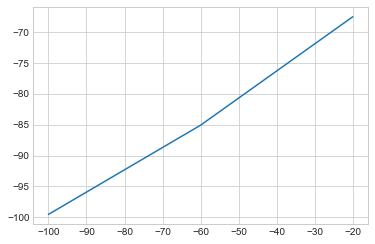

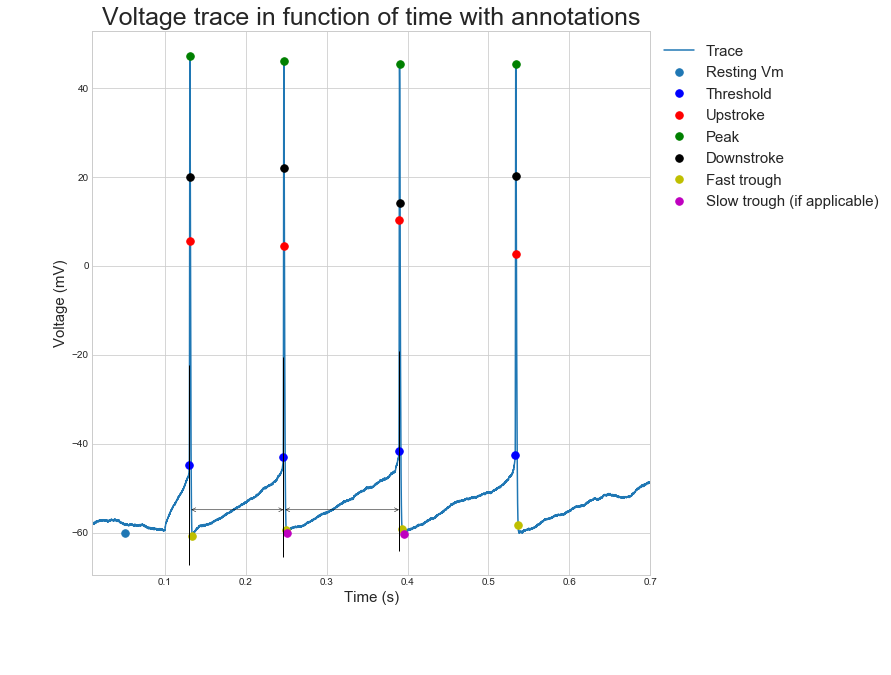

In [257]:
plot_info(HC[0], HC_suppl_info[0])

In [267]:
def plot_info_all(data_tuple, data_tuple_suppl_info, names, directory):
    """ Plots info of the first spike train (with more than 3 peaks)
    Parameters
    ----------
    data_tuple : tuple of dictionaries of data full of voltage (V) and time (s) traces for different cells
    names : tuple of names of the samples
    directory : directory where to output the figures
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Saves
    -------
    Figures in specified directory
    """
    for (data, data_suppl_info, name) in zip(data_tuple, data_tuple_suppl_info, names):
        print('Processing: ', name)
        time, voltage, current = data_preparation(data, data_suppl_info)
        filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
        df, df_related_features = extract_spike_features(time, current, voltage, fil = filter_)
        if ~np.any(df_related_features['spike_count'] >= 3):         # There might be no traces with more than 3 spikes
                                                                     # whatsoever
            continue
        ax = plot_info(data)
        plt.title(name.split('/')[-1].split('.')[0], fontsize = 25)
        plt.savefig('{}{}.png'.format(directory, name.split('/')[-1].split('.')[0]), bbox_inches = 'tight', \
                                                                                     pad_inches = 0.5)
        plt.close()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


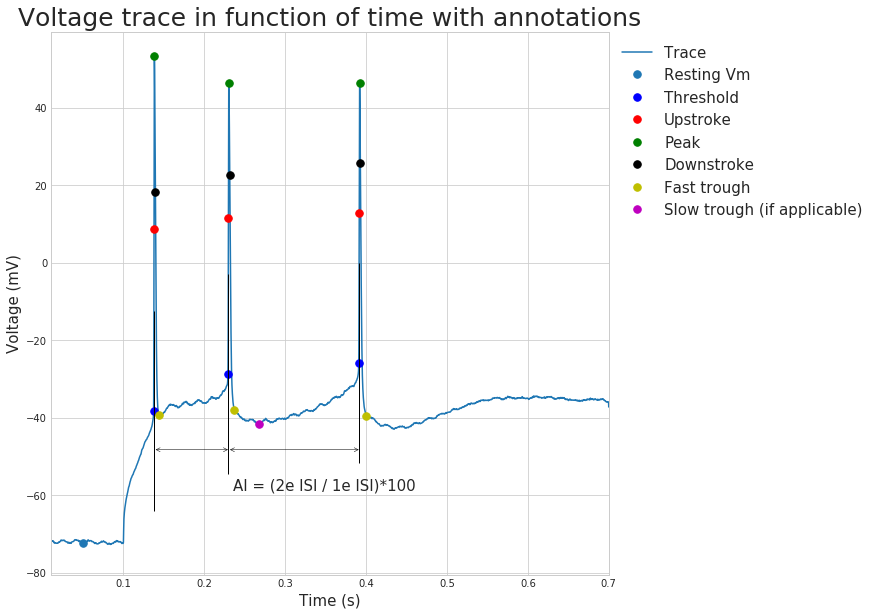

In [356]:
plot_info(data_plot)

In [12]:
directory = '../Hippocampus/Figures_multiple_peaks'
plot_info_all(HC, HC_suppl_info, HC_names, directory)

Processing:  .//06 04 2018 sample 1.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 04 2018 sample 2.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 04 2018 sample 3.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 1.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 05 2018 sample 10.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 05 2018 sample 11.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 12.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 05 2018 sample 13.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 14.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 15.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 16.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 17.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 18.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 19.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 2.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 20.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 3.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 4.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 5.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 05 2018 sample 6.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 7.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 26 2018 sample 11.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 26 2018 sample 12.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 26 2018 sample 13.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 26 2018 sample 15.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 26 2018 sample 16.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 26 2018 sample 17.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 26 2018 sample 2.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 26 2018 sample 6.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 26 2018 sample 7.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 26 2018 sample 8.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 27 2018 sample 1.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 27 2018 sample 13.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 27 2018 sample 3.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 27 2018 sample 8.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 27 2018 sample 9.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 03 2018 sample 11.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 03 2018 sample 14.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 03 2018 sample 15.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 03 2018 sample 2.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 03 2018 sample 3.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 03 2018 sample 7.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 05 2018 sample 2.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 05 2018 sample 6.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

In [13]:
def plot_info_first_peak(data, data_suppl_info):
    """ Analyses a specific data dictionary corresponding to a cell and returns a figure object with annotations on the first
    peak of a particular trace of how certain features have been calculated. Works for data extracted from .mat files, not for
    .asc files.
    Parameters
    ----------
    data : data full of voltage (V) and time (s) for a particular cell
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    start : start of the stimulation (s) in the voltage trace (optional, default 0.1)
    end : end of the stimulation (s) in the voltage trace (optional, default 0.7)
    fil : cutoff frequency for 4-pole low-pass Bessel filter in kHz (optional, default 10)
    
    Returns
    -------
    ax : figure object
    """
    time, voltage, current = data_preparation(data, data_suppl_info)
    filter_ = 7
    if (1/(1e3*(time[1]-time[0]))) < 11: # The sampling frequency is not high at all, so we are forced to change the filter
            filter_ = 5
        df, df_related_features = extract_spike_features(time, current, voltage, fil = filter_)
    Cell_Features = get_cell_features(df, df_related_features)
    current_first = np.flatnonzero(df_related_features['spike_count'].values >=1)[0]


    # Actual current there
    current_first_magn = current[current_first]
    # Amount of spikes there
    spike_count = df_related_features['spike_count'].values[current_first]


    # Find start and end indexes in df for all the spikes in that particular train
    index_start_df = np.flatnonzero(df['threshold_i'].values >= \
    current_first_magn)[0]
    index_end_df = np.flatnonzero(df['threshold_i'].values >= \
    current_first_magn)[0] + spike_count

    # Get threshold, peak, upstroke and downstroke indexes
    thresh_index = np.array(df['threshold_index'].values[index_start_df : index_end_df], dtype = int)
    upstroke_index = np.array(df['upstroke_index'].values[index_start_df : index_end_df], dtype = int)
    peak_index = np.array(df['peak_index'].values[index_start_df : index_end_df], dtype = int)
    downstroke_index = np.array(df['downstroke_index'].values[index_start_df : index_end_df], dtype = int)
    fast_trough_index = np.array(df['fast_trough_index'].values[index_start_df : index_end_df], dtype = int)
    slow_trough_index = df['slow_trough_index'].values[index_start_df : index_end_df]
    slow_trough_index = np.array(slow_trough_index[~np.isnan(slow_trough_index)], dtype = int)

    
    start_index = thresh_index[0]
    end_index = fast_trough_index[0] + 50 # Plot 50 time indices after the fast trough index (should always exist)
        # When last spike is clipped
    if df['clipped'].values[index_end_df-1]:
        return

    f, ax = plt.subplots(figsize = (10, 10))
    ax.plot(time[start_index : end_index], voltage[start_index : end_index, current_first])

    ax.plot(time[thresh_index[0]], voltage[thresh_index[0], current_first], 'b.', ms = 15)
    ax.plot(time[upstroke_index[0]], voltage[upstroke_index[0], current_first], 'r.', ms = 15)
    ax.plot(time[peak_index[0]], voltage[peak_index[0], current_first], 'g.', ms = 15)
    ax.plot(time[downstroke_index[0]], voltage[downstroke_index[0], current_first], 'k.', ms = 15)
    ax.plot(time[fast_trough_index[0]], voltage[fast_trough_index[0], current_first], 'y.', ms = 15)
    if slow_trough_index.size:
        ax.plot(time[slow_trough_index[0]], voltage[slow_trough_index[0], current_first], 'm.')
        ax.legend(['Trace', 'Threshold', 'Upstroke', 'Peak', 'Downstroke', 'Fast trough', 'Slow trough (if applicable)'])
    else:
        ax.legend(['Trace', 'Threshold', 'Upstroke', 'Peak', 'Downstroke', 'Fast trough'])
    ax.set_xlabel('Time (s)', fontsize = 15)
    ax.set_ylabel('Voltage (mV)', fontsize = 15)
    ax.set_title('First peak annotations (voltage i.f.o. time)', fontsize = 25)

    # Nice annotations

    ax.annotate('', xy = (time[peak_index[0]], voltage[peak_index[0], current_first]), \
                xycoords = 'data', xytext = (time[peak_index[0]], voltage[thresh_index[0], current_first]), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'connectionstyle': 'arc3', 'lw': 4, 'shrinkB': 0})
    ax.plot(time[peak_index[0]], voltage[thresh_index[0], current_first], '_', color = 'black', ms = 100)
    ax.plot(time[peak_index[0]], voltage[peak_index[0], current_first], '_', color = 'black', ms = 100)


    width_level = (voltage[peak_index[0], current_first] - voltage[thresh_index[0], current_first])/2 + \
                   voltage[thresh_index[0], current_first]
    width_start_index = peak_index[0] - np.flatnonzero(voltage[peak_index[0] : thresh_index[0]:-1, current_first] <= width_level)[0]
    width_end_index = peak_index[0] + np.flatnonzero(voltage[peak_index[0]: fast_trough_index[0], current_first] <=width_level)[0]
    plt.plot(time[width_start_index], voltage[width_start_index, current_first], '|', color = 'black', ms = 100)
    plt.plot(time[width_end_index], voltage[width_end_index, current_first], '|', color = 'black', ms = 100)

    # The half-width itself is calculated based on t[width_end_index] - t[width_start_index], but the voltages might be different
    # at the respective indices, thus we choose the arrow to go from v[width_start_index] to v[width_start_index] to make
    # it horizontal (interpretability of the figure improves)
    ax.annotate('', xy = (time[width_start_index], voltage[width_start_index, current_first]), \
                xycoords = 'data', xytext = (time[width_end_index], voltage[width_start_index, current_first]), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'connectionstyle': 'arc3', 'lw': 4, 'shrinkA': 0})
    ax.annotate('AP half-width', xy = (time[width_start_index], \
                 width_level - 5), xycoords='data', xytext = (5, 0), textcoords = 'offset points', fontsize = 15)

    # For the AP amplitude
    ax.annotate('AP amplitude', xy = (time[peak_index[0]], width_level + 20), \
                 xycoords = 'data', xytext = (5, 0), textcoords = 'offset points', fontsize = 15)
    
    return ax

In [14]:
def plot_info_first_peak_all(data_tuple, data_tuple_suppl_info, names, directory):
    """ Plots info of the first spike train (with more than 3 peaks)
    Parameters
    ----------
    data_tuple : tuple of dictionaries of data full of voltage (V) and time (s) traces for different cells
    names : tuple of names of the samples
    directory : directory where to output the figures
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Saves
    -------
    Figures in specified directory
    """
    for (data, data_suppl_info, name) in zip(data_tuple, data_tuple_suppl_info, names):
        print('Processing: ', name)
        time, voltage, current = data_preparation(data, data_suppl_info)
        filter_ = 7
        if (1/(1e3*(time[1]-time[0]))) < 11: # The sampling frequency is not high at all, so we are forced to change the filter
            filter_ = 5
        df, df_related_features = extract_spike_features(time, current, voltage)
        if ~np.any(df_related_features['spike_count'] >= 1):
            continue
        ax = plot_info_first_peak(data, data_suppl_info)
        plt.title(name.split('/')[-1].split('.')[0], fontsize = 25)
        plt.savefig('{}{}.png'.format(directory, name.split('/')[-1].split('.')[0]), bbox_inches = 'tight', \
                                                                                     pad_inches = 0.5)
        plt.close()

In [15]:
directory = '../Hippocampus/Figures_first_peak'
plot_info_first_peak_all(HC, HC_suppl_info, HC_names, directory)

Processing:  .//06 04 2018 sample 1.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 04 2018 sample 2.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 04 2018 sample 3.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 1.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 05 2018 sample 10.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 11.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 12.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 05 2018 sample 13.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 14.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 15.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 16.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 17.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 18.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 19.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 2.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 20.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 05 2018 sample 3.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 4.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 5.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 6.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 7.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 26 2018 sample 11.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 26 2018 sample 12.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 26 2018 sample 13.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 26 2018 sample 15.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 26 2018 sample 16.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 26 2018 sample 17.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 26 2018 sample 2.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 26 2018 sample 6.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 26 2018 sample 7.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 26 2018 sample 8.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 27 2018 sample 1.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 27 2018 sample 13.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 27 2018 sample 3.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 27 2018 sample 8.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 27 2018 sample 9.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 03 2018 sample 11.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 03 2018 sample 14.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 03 2018 sample 15.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 03 2018 sample 2.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 03 2018 sample 3.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 03 2018 sample 7.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 05 2018 sample 2.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 05 2018 sample 6.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
